In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib as mpl

import matplotlib.cm as cm

import plotly.graph_objects as go
import plotly
from plotly.subplots import make_subplots

import warnings 
warnings.filterwarnings("ignore")

pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_columns', 100)

import random

from itertools import combinations
from collections import Counter

## Reset option remove scientific notation
# pd.reset_option('display.float_format')

In [2]:
df = pd.read_csv('Clustering All.csv')
display(df.head(4), df.shape)

,Invoice,StockCode,Description,Quantity,Price,Amount,Customer ID,Country,InvoiceDate,Day of Week,Date,Month,Year,Day of Year,Week of Year,Time Hour,Hour,Date Full,Recency,Frequency,Monetary,R,F,M,RFM Score,RFM_Sum,Segment,RecencyLS,FrequencyLS,MonetaryLS,ClusterLog
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,6.95,83.40,13085.0,United Kingdom,2009-12-01 07:45:00,Tuesday,1,Dec,2009,335,48,07:45:00,7,2009-12-01,158,84,2433.28,3,3,4,334,10,Loyal customers,5.06,4.43,7.80,Cluster A
1,489434,79323P,PINK CHERRY LIGHTS,12,6.75,81.00,13085.0,United Kingdom,2009-12-01 07:45:00,Tuesday,1,Dec,2009,335,48,07:45:00,7,2009-12-01,158,84,2433.28,3,3,4,334,10,Loyal customers,5.06,4.43,7.80,Cluster A
2,489434,79323W,WHITE CHERRY LIGHTS,12,6.75,81.00,13085.0,United Kingdom,2009-12-01 07:45:00,Tuesday,1,Dec,2009,335,48,07:45:00,7,2009-12-01,158,84,2433.28,3,3,4,334,10,Loyal customers,5.06,4.43,7.80,Cluster A
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2.10,100.80,13085.0,United Kingdom,2009-12-01 07:45:00,Tuesday,1,Dec,2009,335,48,07:45:00,7,2009-12-01,158,84,2433.28,3,3,4,334,10,Loyal customers,5.06,4.43,7.80,Cluster A


(1003214, 31)

In [3]:
df9 = df[df['Year'] == 2009] # In year 2009
dfr = df[df['Year'] != 2009] # Exclude year 2009

cats_month = ['Jan', 'Feb', 'Mar', 'Apr','May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov','Dec']
dfr['Month'] = pd.Categorical(dfr['Month'], ordered=True, categories=cats_month)
df9['Month'] = pd.Categorical(df9['Month'], ordered=True, categories=cats_month)
df['Month'] = pd.Categorical(df['Month'], ordered=True, categories=cats_month)

cats_day = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
dfr['Day of Week'] = pd.Categorical(dfr['Day of Week'], ordered=True, categories=cats_day)
df9['Day of Week'] = pd.Categorical(df9['Day of Week'], ordered=True, categories=cats_day)
df['Day of Week'] = pd.Categorical(df['Day of Week'], ordered=True, categories=cats_day)

cats_date = [i for i in range(1,32)]
dfr['Date'] = pd.Categorical(dfr['Date'], ordered=True, categories=cats_date)
df9['Date'] = pd.Categorical(df9['Date'], ordered=True, categories=cats_date)
df['Date'] = pd.Categorical(df['Date'], ordered=True, categories=cats_date)


cats_hour = [hour for hour in range(1,25)]
dfr['Hour'] = pd.Categorical(dfr['Hour'], ordered=True, categories=cats_hour)
df9['Hour'] = pd.Categorical(df9['Hour'], ordered=True, categories=cats_hour)
df['Hour'] = pd.Categorical(df['Hour'], ordered=True, categories=cats_hour)

cats_week = [i for i in range(1, 53)]
dfr['Week of Year'] = pd.Categorical(dfr['Week of Year'], ordered=True, categories=cats_week)
df9['Week of Year'] = pd.Categorical(df9['Week of Year'], ordered=True, categories=cats_week)
df['Week of Year'] = pd.Categorical(df['Week of Year'], ordered=True, categories=cats_week)

In [4]:
df.groupby(['ClusterLog','Segment'])[['Monetary']].sum().sort_values(by='ClusterLog').reset_index()

,ClusterLog,Segment,Monetary
0,Cluster A,At risk,91511269.10
1,Cluster A,Can't loose them,599862417.88
2,Cluster A,Champions,210518.48
3,Cluster A,Hibernating,7487407.02
4,Cluster A,Loyal customers,325335889.28
5,Cluster A,Potential loyalists,3238677.99
6,Cluster A,Promising,160290.30
7,Cluster B,Champions,33574750.80
8,Cluster B,Loyal customers,10024858.23
9,Cluster B,New customers,450823.49


In [5]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], format='%Y-%m-%d %H:%M:%S')
df['Date Full'] = pd.to_datetime(df['InvoiceDate'].dt.strftime('%Y-%m-%d'))
df['Date Full'].max()

Timestamp('2011-12-09 00:00:00')

In [6]:
a = '2011-12-10'
last = pd.to_datetime(a, format='%Y-%m-%d')
(last - df['Date Full'].max()).days

1

## Clustering and RFM

In [7]:
len(df['Customer ID'].unique())

8774

In [8]:
rfmclus = df.groupby(['ClusterLog','Segment','Customer ID'], as_index=False).agg({'Date Full': lambda x : (last - x.max()).days,
                                                                    'Invoice': lambda x : len(x),
                                                                    'Amount': lambda x : x.sum()})

rfmclus.rename(columns={'ClusterLog':'Cluster','Date Full':'Recency',
                        'Invoice':'Frequency','Amount':'Monetary'}, inplace=True)

In [9]:
rfmclus

,Cluster,Segment,Customer ID,Recency,Frequency,Monetary
0,Cluster A,At risk,12354.0,233,58,1079.40
1,Cluster A,At risk,12369.0,414,90,1511.15
2,Cluster A,At risk,12373.0,312,48,927.65
3,Cluster A,At risk,12385.0,380,64,1668.40
4,Cluster A,At risk,12389.0,403,49,1433.33
...,...,...,...,...,...,...
8769,Cluster E,Promising,imp7534,51,7,42.28
8770,Cluster E,Promising,imp7535,51,2,15.20
8771,Cluster E,Promising,imp7537,50,4,7.46
8772,Cluster E,Promising,imp7547,47,5,16.92


In [10]:
rfmclus[rfmclus['Cluster'] == 'Cluster D']['Segment'].value_counts()

Champions              1234
Loyal customers         146
Potential loyalists      10
New customers             2
Can't loose them          1
Name: Segment, dtype: int64

In [11]:
rfmclus[rfmclus['Cluster'] == 'Cluster A']['Segment'].value_counts()

Loyal customers        895
At risk                635
Can't loose them       594
Hibernating             98
Potential loyalists     55
Promising                2
Champions                1
Name: Segment, dtype: int64

In [12]:
rfmclus[rfmclus['Cluster'] == 'Cluster B']['Segment'].value_counts()

Potential loyalists    567
Champions              442
Loyal customers        178
New customers          134
Promising               47
Name: Segment, dtype: int64

In [13]:
rfmclus[rfmclus['Cluster'] == 'Cluster C']['Segment'].value_counts()

Hibernating            1855
Potential loyalists     229
At risk                 193
Promising               175
Loyal customers          44
Name: Segment, dtype: int64

In [14]:
rfmclus[rfmclus['Cluster'] == 'Cluster E']['Segment'].value_counts()

Hibernating            978
Promising              193
New customers           65
Potential loyalists      1
Name: Segment, dtype: int64

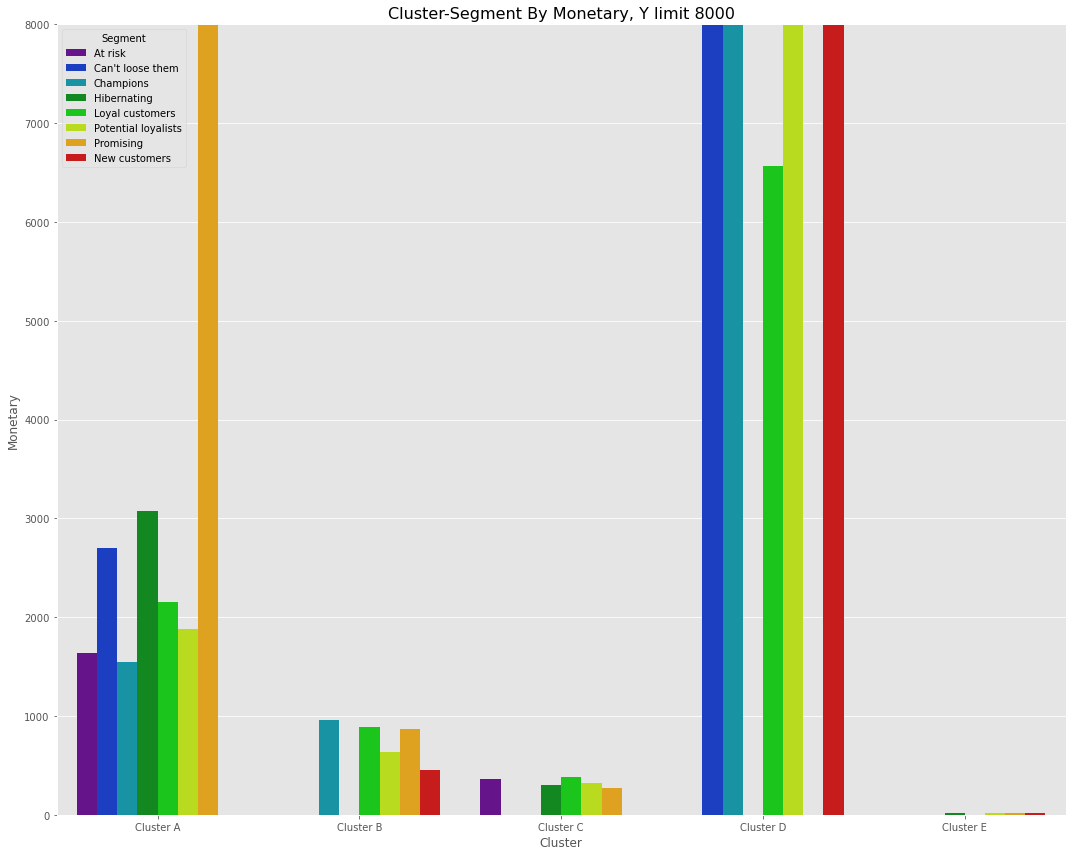

In [15]:
plt.style.use('ggplot')
plt.figure(figsize=(15,12))
sns.barplot(x='Cluster', y='Monetary', hue='Segment', data=rfmclus, ci=None, palette='nipy_spectral')
plt.title('Cluster-Segment By Monetary, Y limit 8000', size=16)
plt.ylim([0,8000])
plt.tight_layout()
plt.savefig('Cluster-Segment By Monetary.jpeg',
            pil_kwargs={'quality': 95,'papertype':'letter'});

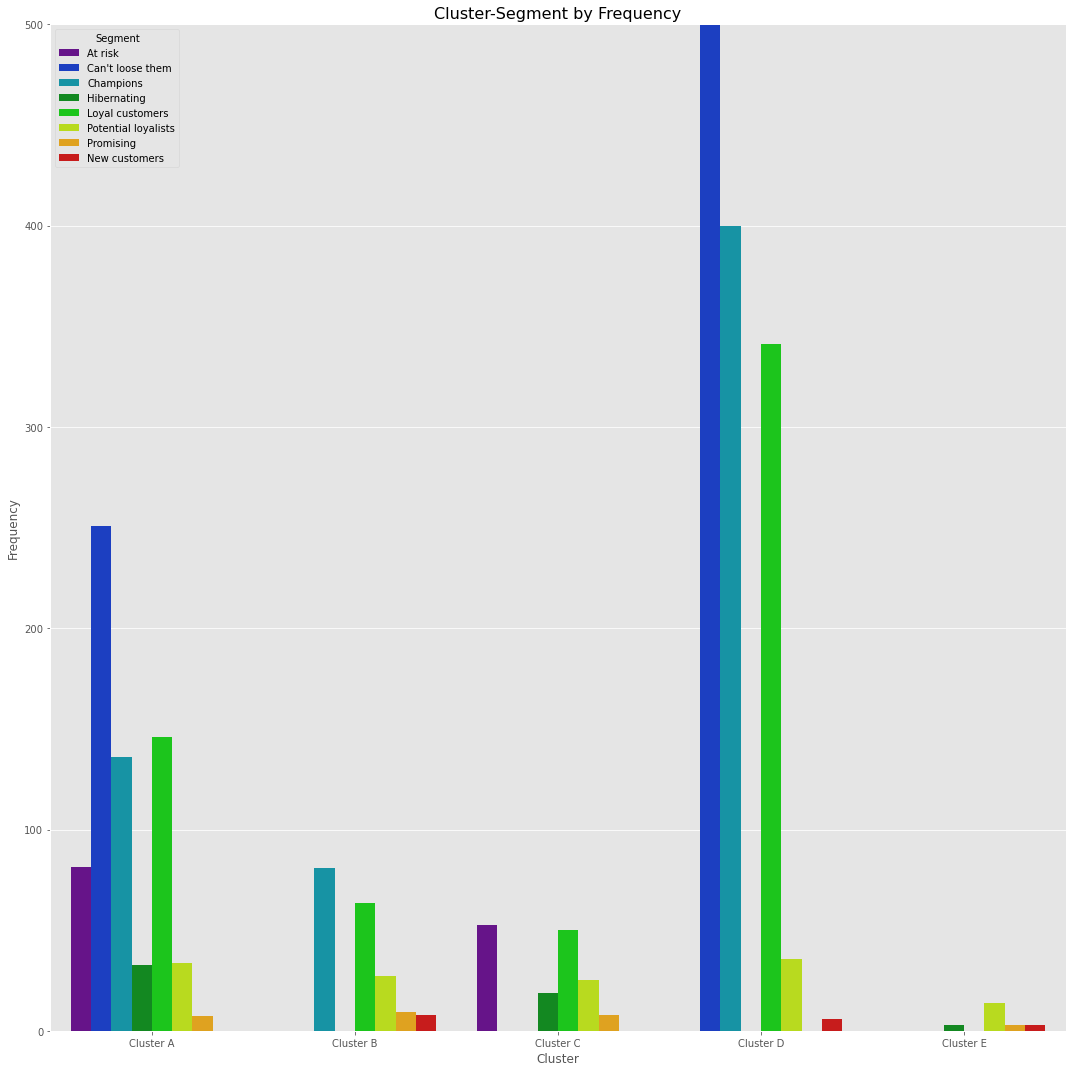

In [16]:
plt.style.use('ggplot')
plt.figure(figsize=(15,15))
sns.barplot(x='Cluster', y='Frequency', hue='Segment', data=rfmclus, ci=None, palette='nipy_spectral')
plt.title('Cluster-Segment by Frequency', size=16)
plt.ylim([0,500])
plt.tight_layout()
plt.savefig('Cluster-Segment by Frequency.jpeg',
            pil_kwargs={'quality': 95,'papertype':'letter'});

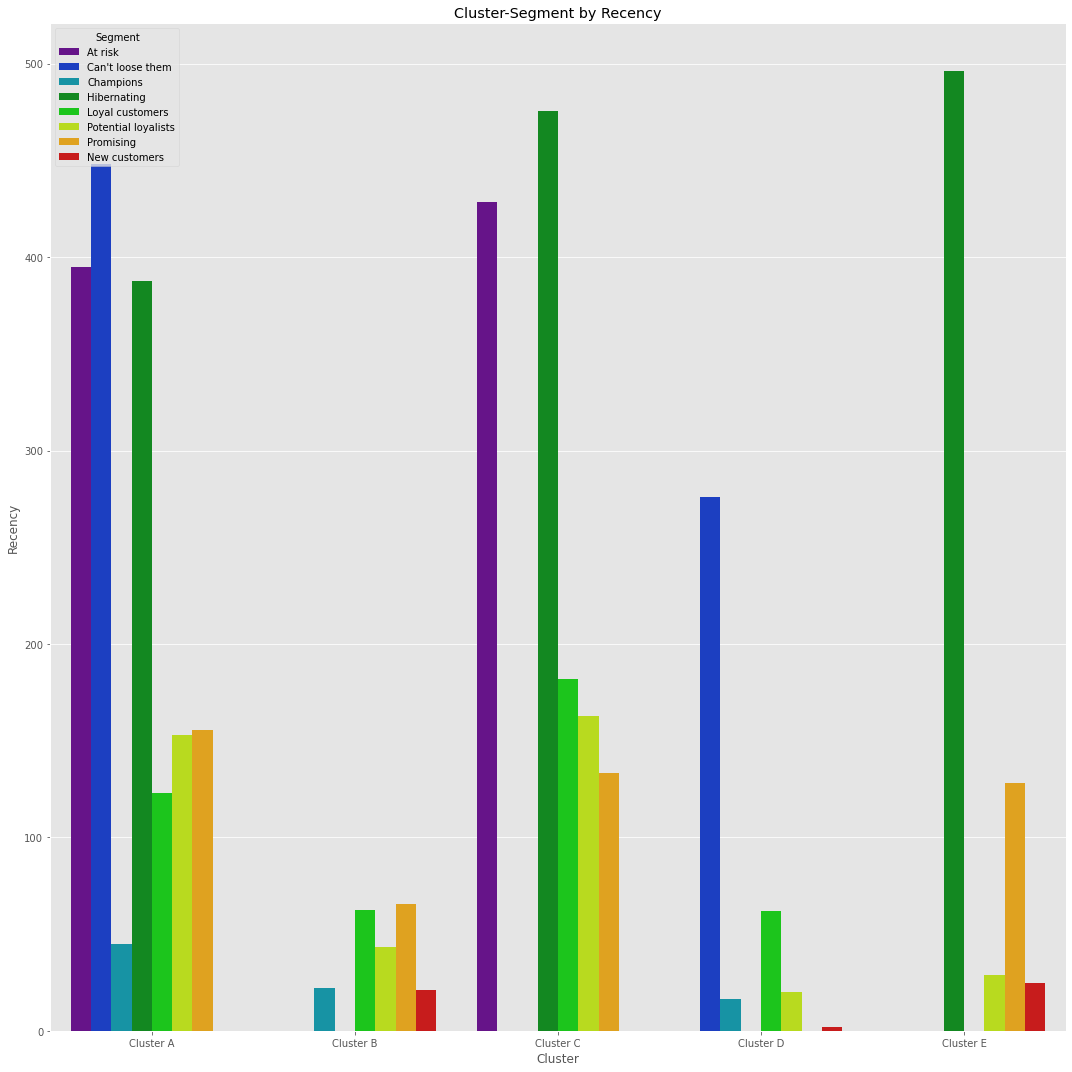

In [17]:
plt.style.use('ggplot')
plt.figure(figsize=(15,15))
sns.barplot(x='Cluster', y='Recency', hue='Segment', data=rfmclus, ci=None, palette='nipy_spectral')
plt.title('Cluster-Segment by Recency')
plt.tight_layout()
plt.savefig('Cluster-Segment by Recency.jpeg',
            pil_kwargs={'quality': 95,'papertype':'letter'});

In [18]:
from matplotlib import cm

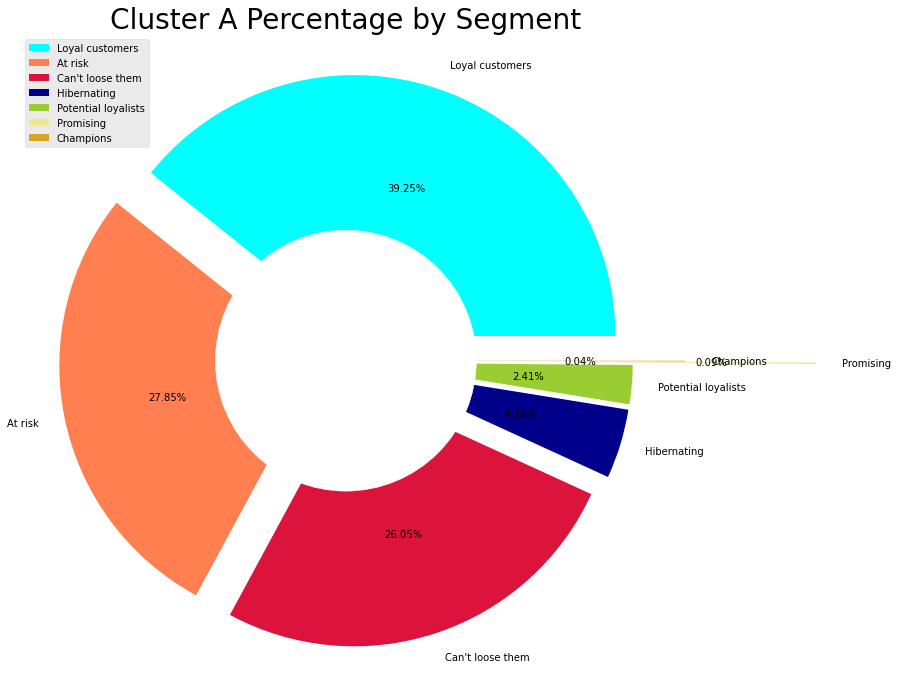

In [19]:
plt.figure(figsize=(15,12))
colors = ['aqua', 'coral', 'crimson', 'darkblue', 'yellowgreen', 'khaki', 'goldenrod']

explode = [0.1, 0.1, 0.1, 0.1, 0.1, .8, .3]

circle = plt.Circle((0, 0), 0.5, color = 'white')

plt.pie(rfmclus[rfmclus['Cluster'] == 'Cluster A']['Segment'].value_counts(), 
        colors = colors, 
        labels = rfmclus[rfmclus['Cluster'] == 'Cluster A']['Segment'].value_counts().keys(),
        explode = explode, shadow = False, autopct = '%.2f%%')
plt.title('Cluster A Percentage by Segment', fontsize = 28)
p = plt.gcf()
p.gca().add_artist(circle)
plt.axis('off')
plt.legend()
plt.savefig('Cluster A Percentage by Segment.jpeg',
            pil_kwargs={'quality': 95,'papertype':'letter'});

In [20]:
rfmclus[rfmclus['Cluster'] == 'Cluster B']['Segment'].value_counts().keys()

Index(['Potential loyalists', 'Champions', 'Loyal customers', 'New customers',
       'Promising'],
      dtype='object')

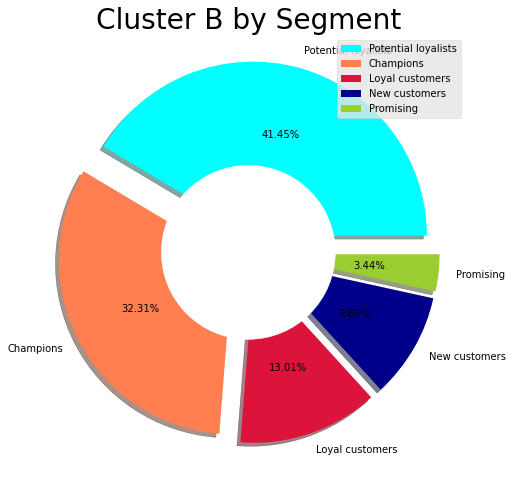

In [21]:
plt.figure(figsize=(12,8))
colors = ['aqua', 'coral', 'crimson', 'darkblue', 'yellowgreen', 'khaki', 'goldenrod']

explode = [0.1, 0.1, 0.1, 0.1, 0.1]

circle = plt.Circle((0, 0), 0.5, color = 'white')

plt.pie(rfmclus[rfmclus['Cluster'] == 'Cluster B']['Segment'].value_counts(), 
        colors = colors, 
        labels = rfmclus[rfmclus['Cluster'] == 'Cluster B']['Segment'].value_counts().keys(),
        explode = explode, shadow = True, autopct = '%.2f%%')
plt.title('Cluster B by Segment', fontsize = 28)
p = plt.gcf()
p.gca().add_artist(circle)
plt.axis('off')
plt.legend(loc=0)
plt.savefig('Cluster B Percentage by Segment.jpeg',
            pil_kwargs={'quality': 95,'papertype':'letter'});

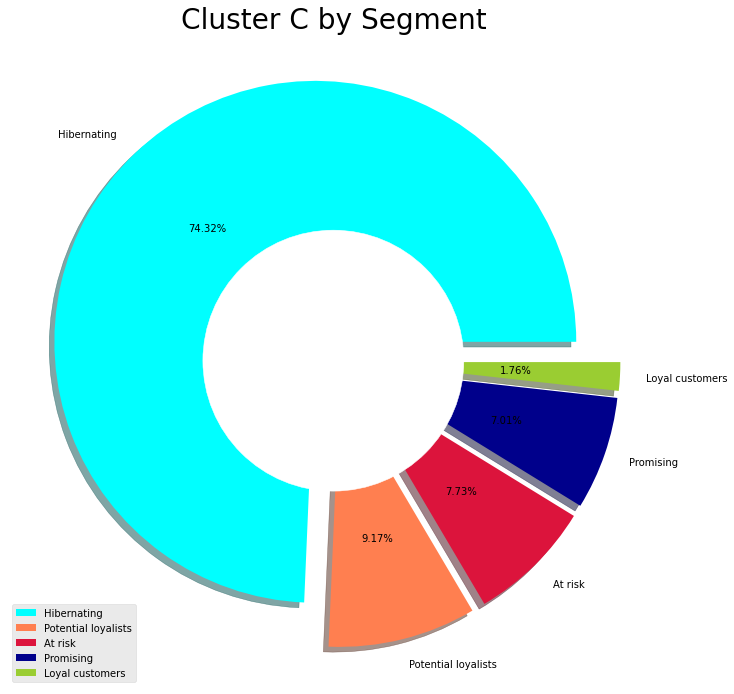

In [22]:
plt.figure(figsize=(15,12))
colors = ['aqua', 'coral', 'crimson', 'darkblue', 'yellowgreen', 'khaki', 'goldenrod']

explode = [0.1, 0.1, 0.1, 0.1, 0.1]

circle = plt.Circle((0, 0), 0.5, color = 'white')

plt.pie(rfmclus[rfmclus['Cluster'] == 'Cluster C']['Segment'].value_counts(), 
        colors = colors, 
        labels = rfmclus[rfmclus['Cluster'] == 'Cluster C']['Segment'].value_counts().keys(),
        explode = explode, shadow = True, autopct = '%.2f%%')
plt.title('Cluster C by Segment', fontsize = 28)
p = plt.gcf()
p.gca().add_artist(circle)
plt.axis('off')
plt.legend()
plt.savefig('Cluster C Percentage by Segment.jpeg',
            pil_kwargs={'quality': 95,'papertype':'letter'});

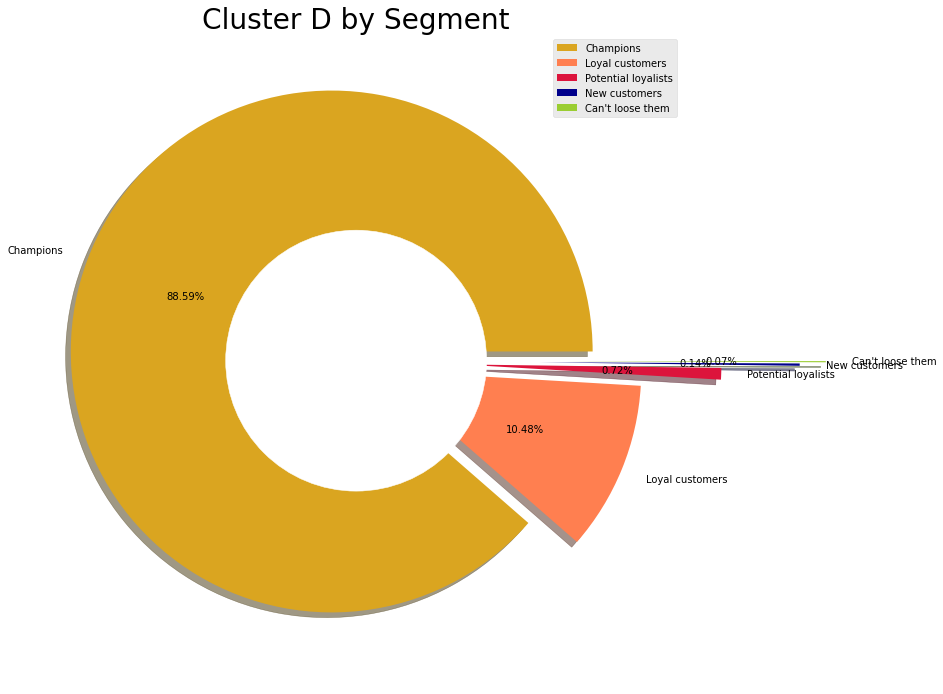

In [23]:
plt.figure(figsize=(15,12))
colors = ['goldenrod', 'coral', 'crimson', 'darkblue', 'yellowgreen', 'khaki']

explode = [0.1, 0.1, 0.4, 0.7, 0.8]

circle = plt.Circle((0, 0), 0.5, color = 'white')

plt.pie(rfmclus[rfmclus['Cluster'] == 'Cluster D']['Segment'].value_counts(), 
        colors = colors, 
        labels = rfmclus[rfmclus['Cluster'] == 'Cluster D']['Segment'].value_counts().keys(),
        explode = explode, shadow = True, autopct = '%.2f%%')
plt.title('Cluster D by Segment', fontsize = 28)
p = plt.gcf()
p.gca().add_artist(circle)
plt.axis('off')
plt.legend()
plt.savefig('Cluster D Percentage by Segment.jpeg',
            pil_kwargs={'quality': 95,'papertype':'letter'});

In [24]:
rfmclus[rfmclus['Cluster'] == 'Cluster E']['Segment'].value_counts().keys()

Index(['Hibernating', 'Promising', 'New customers', 'Potential loyalists'], dtype='object')

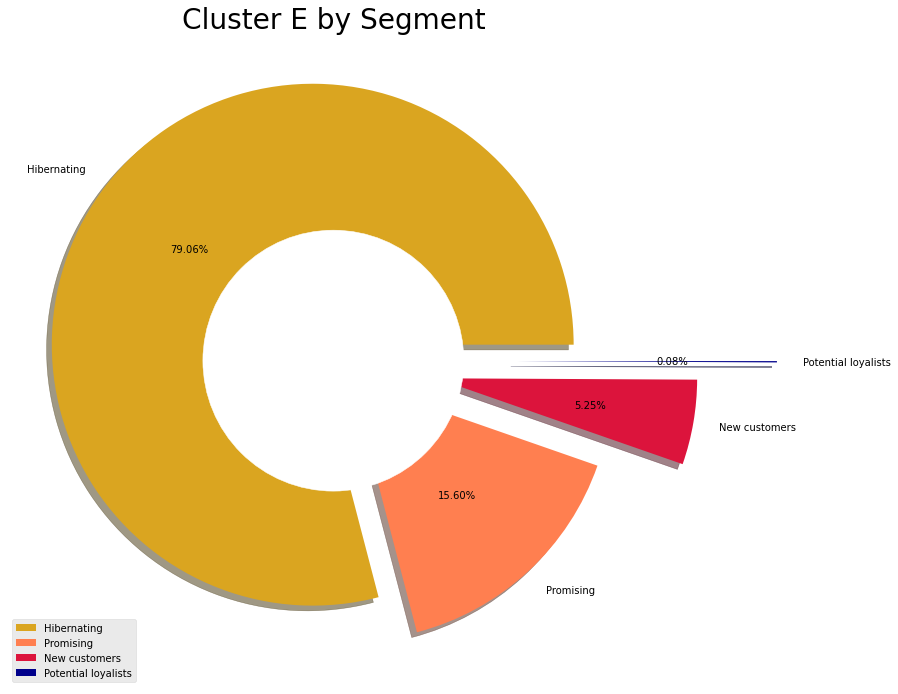

In [25]:
plt.figure(figsize=(15,12))
colors = ['goldenrod', 'coral', 'crimson', 'darkblue', 'yellowgreen', 'khaki']

explode = [0.1, 0.1, 0.4, 0.7]

circle = plt.Circle((0, 0), 0.5, color = 'white')

plt.pie(rfmclus[rfmclus['Cluster'] == 'Cluster E']['Segment'].value_counts(), 
        colors = colors, 
        labels = rfmclus[rfmclus['Cluster'] == 'Cluster E']['Segment'].value_counts().keys(),
        explode = explode, shadow = True, autopct = '%.2f%%')
plt.title('Cluster E by Segment', fontsize = 28)
p = plt.gcf()
p.gca().add_artist(circle)
plt.axis('off')
plt.legend()
plt.savefig('Cluster E Percentage by Segment.jpeg',
            pil_kwargs={'quality': 95,'papertype':'letter'});

# **Product Exploration by Cluster and Segment**

In [26]:
prod_clus = df.groupby(['ClusterLog','Segment','Description','Country'], as_index=False)[['Invoice']].count().sort_values(by='Invoice', ascending=False)
prod_clus

,ClusterLog,Segment,Description,Country,Invoice
71421,Cluster D,Champions,WHITE HANGING HEART T-LIGHT HOLDER,United Kingdom,2623
60714,Cluster D,Champions,JUMBO BAG RED RETROSPOT,United Kingdom,1714
66178,Cluster D,Champions,REGENCY CAKESTAND 3 TIER,United Kingdom,1681
53160,Cluster D,Champions,ASSORTED COLOUR BIRD ORNAMENT,United Kingdom,1448
61443,Cluster D,Champions,LUNCH BAG BLACK SKULL.,United Kingdom,1384
...,...,...,...,...,...
37473,Cluster B,Potential loyalists,OVERNIGHT BAG VINTAGE ROSE PAISLEY,United Kingdom,1
37474,Cluster B,Potential loyalists,OWL DOORSTOP,France,1
37477,Cluster B,Potential loyalists,PACK 20 DOLLY PEGS,United Kingdom,1
37480,Cluster B,Potential loyalists,PACK 3 BOXES CHRISTMAS PANNETONE,Germany,1


## Cluster A

In [27]:
prod_clus_A = prod_clus[prod_clus['ClusterLog'] == 'Cluster A'][['Segment','Description','Invoice','Country']].head(30)
prod_clus_A

,Segment,Description,Invoice,Country
24265,Loyal customers,WHITE HANGING HEART T-LIGHT HOLDER,734,United Kingdom
12315,Can't loose them,WHITE HANGING HEART T-LIGHT HOLDER,646,United Kingdom
21690,Loyal customers,REGENCY CAKESTAND 3 TIER,469,United Kingdom
11925,Can't loose them,STRAWBERRY CERAMIC TRINKET BOX,422,United Kingdom
20357,Loyal customers,PARTY BUNTING,415,United Kingdom
18846,Loyal customers,JUMBO BAG RED RETROSPOT,371,United Kingdom
15093,Loyal customers,ASSORTED COLOUR BIRD ORNAMENT,353,United Kingdom
11092,Can't loose them,REGENCY CAKESTAND 3 TIER,342,United Kingdom
10397,Can't loose them,PARTY BUNTING,334,United Kingdom
12400,Can't loose them,WOODEN FRAME ANTIQUE WHITE,334,United Kingdom


In [28]:
prod_clus_A['Grouped'] = prod_clus_A.groupby('Invoice')['Description'].transform(lambda x: ','.join(x))
count = Counter()

for row in prod_clus_A['Grouped']:
    row_list = row.split(',')
    count.update(Counter(combinations(row_list, 2)))

count.most_common(10)

[(('PARTY BUNTING', 'WOODEN FRAME ANTIQUE WHITE '), 2)]

In [29]:
mpl.rcParams.update(mpl.rcParamsDefault)

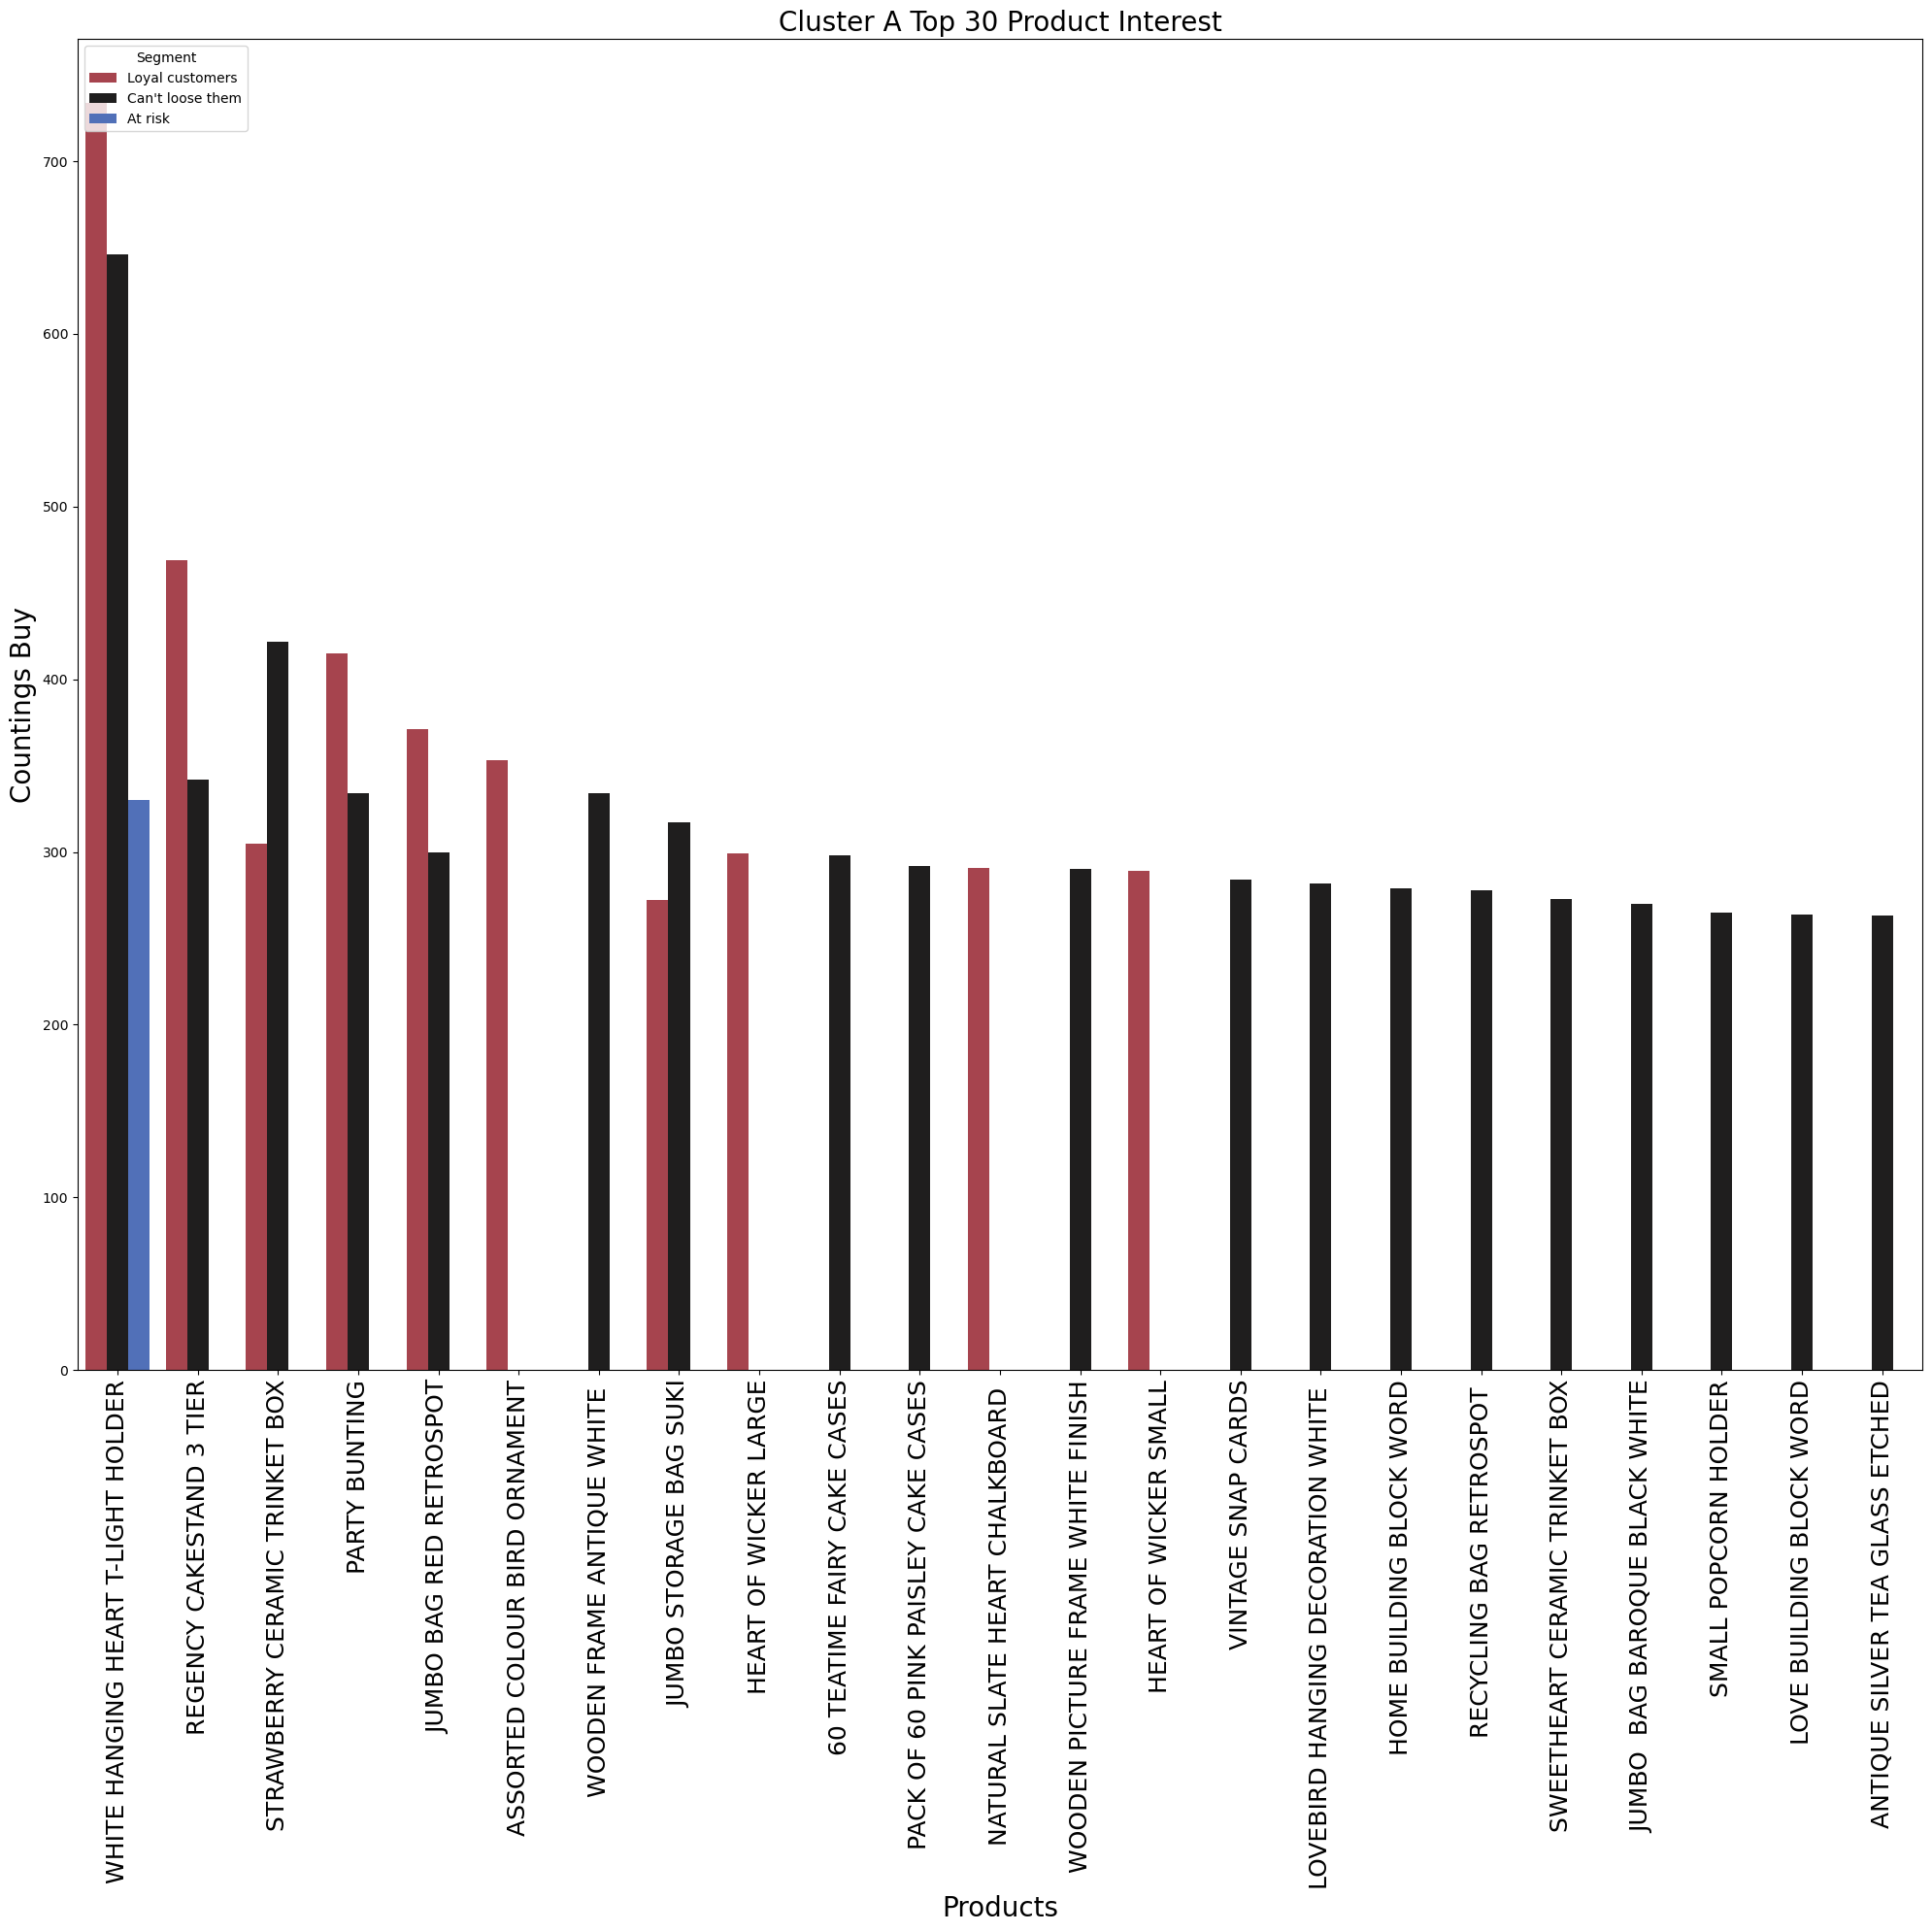

In [30]:
plt.figure(figsize=(20,20))
sns.barplot(x= 'Description', y= 'Invoice',
            data=prod_clus_A, hue='Segment',
            palette = 'icefire_r',
            ci=None)
plt.xticks(size=18,rotation=90)
plt.xlabel(xlabel='Products',size=20)
plt.ylabel('Countings Buy', size=20)
plt.title('Cluster A Top 30 Product Interest', size=20)
plt.tight_layout()
plt.savefig('Cluster A Top 30 Product Interest.jpeg',
            pil_kwargs={'quality': 95,'papertype':'letter'});

## Cluster B

In [31]:
prod_clus_B = prod_clus[prod_clus['ClusterLog'] == 'Cluster B'][['Segment','Description','Invoice','Country']].head(30)
prod_clus_B

,Segment,Description,Invoice,Country
29455,Champions,REX CASH+CARRY JUMBO SHOPPER,154,United Kingdom
30669,Champions,WHITE HANGING HEART T-LIGHT HOLDER,147,United Kingdom
26057,Champions,ASSORTED COLOUR BIRD ORNAMENT,129,United Kingdom
28709,Champions,PAPER CHAIN KIT 50'S CHRISTMAS,122,United Kingdom
28457,Champions,NATURAL SLATE HEART CHALKBOARD,115,United Kingdom
26120,Champions,BAKING SET 9 PIECE RETROSPOT,103,United Kingdom
29348,Champions,REGENCY CAKESTAND 3 TIER,102,United Kingdom
39218,Potential loyalists,WHITE HANGING HEART T-LIGHT HOLDER,101,United Kingdom
26709,Champions,CHOCOLATE HOT WATER BOTTLE,96,United Kingdom
27781,Champions,HEART OF WICKER SMALL,92,United Kingdom


In [32]:
prod_clus_B['Grouped'] = prod_clus_B.groupby('Invoice')['Description'].transform(lambda x: ','.join(x))
count = Counter()

for row in prod_clus_B['Grouped']:
    row_list = row.split(',')
    count.update(Counter(combinations(row_list, 2)))

count.most_common(10)

[(('WOODEN HEART CHRISTMAS SCANDINAVIAN', 'HOT WATER BOTTLE KEEP CALM'), 3),
 (('WOODEN HEART CHRISTMAS SCANDINAVIAN', 'RETROSPOT TEA SET CERAMIC 11 PC '),
  3),
 (('HOT WATER BOTTLE KEEP CALM', 'RETROSPOT TEA SET CERAMIC 11 PC '), 3),
 (('HEART OF WICKER SMALL', 'PAPER CHAIN KIT VINTAGE CHRISTMAS'), 2),
 (('HOT WATER BOTTLE TEA AND SYMPATHY', 'SCOTTIE DOG HOT WATER BOTTLE'), 2),
 (('VINTAGE SNAP CARDS', 'HEART OF WICKER LARGE'), 2),
 (('BAKING SET 9 PIECE RETROSPOT ', 'WHITE HANGING HEART T-LIGHT HOLDER'), 2)]

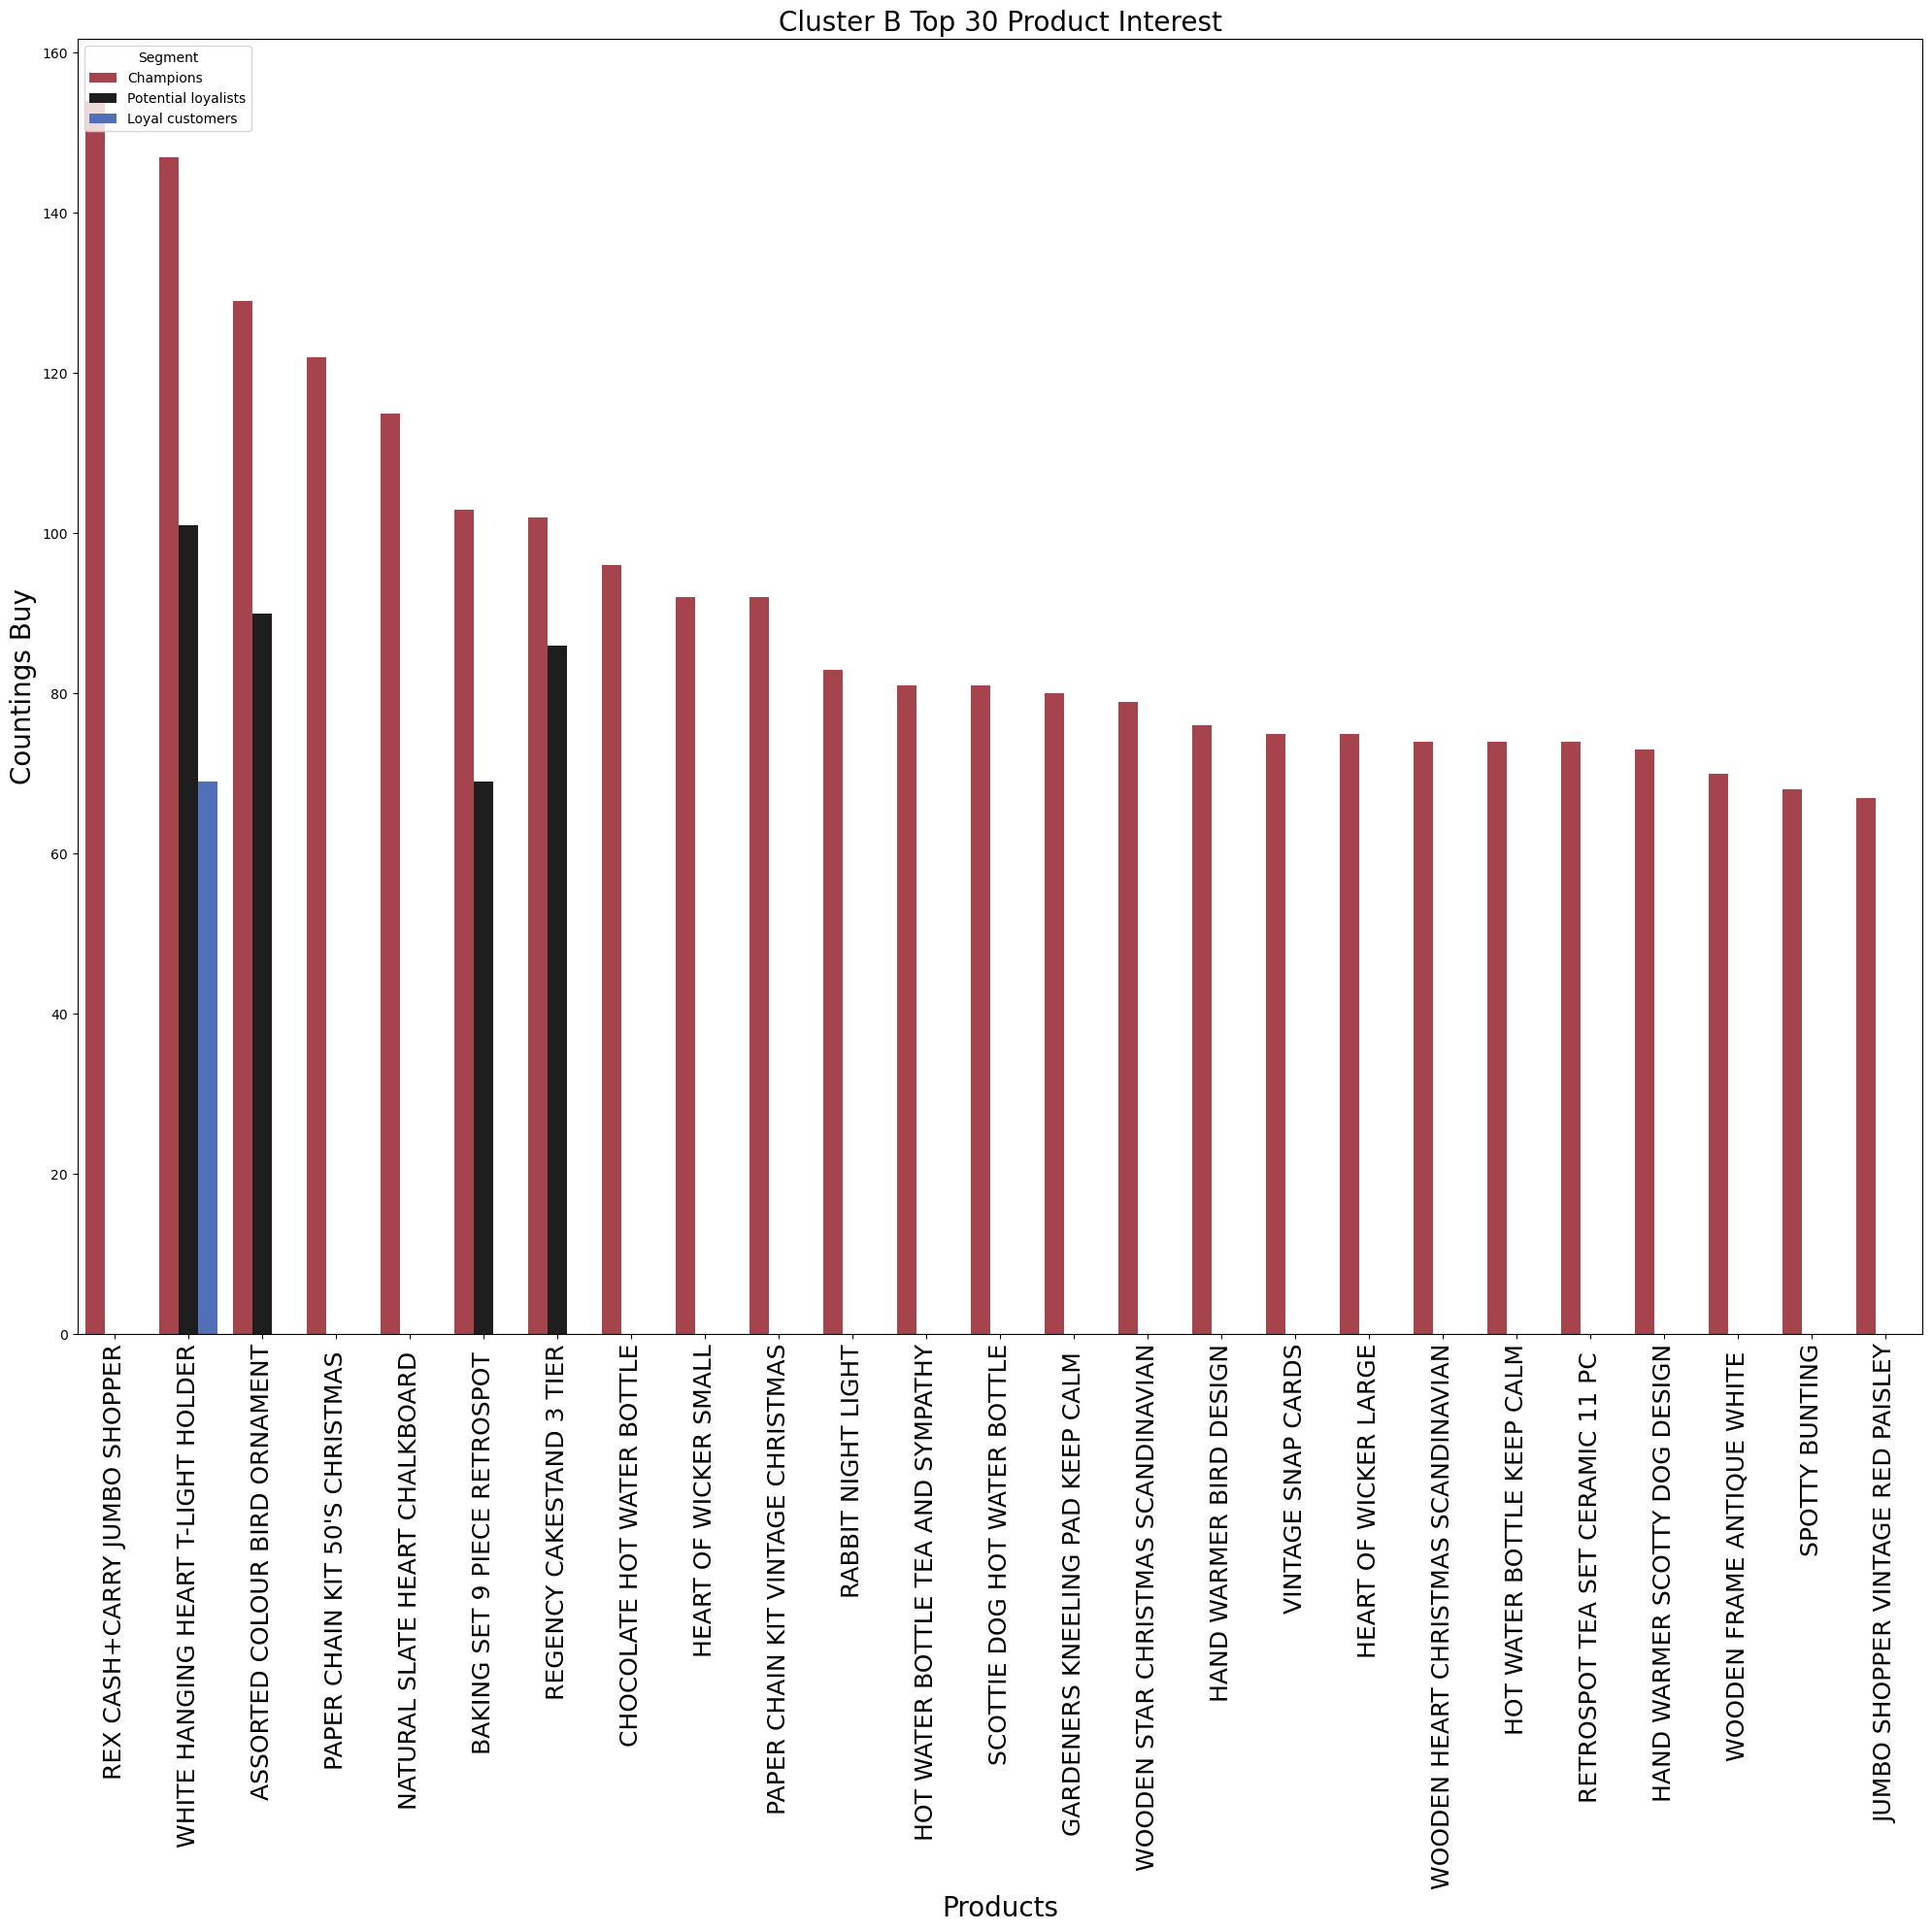

In [33]:
plt.figure(figsize=(20,20))
sns.barplot(x= 'Description', y= 'Invoice',
            data=prod_clus_B, hue='Segment',
            palette = 'icefire_r',
            ci=None)
plt.xticks(size=18,rotation=90)
plt.xlabel(xlabel='Products',size=20)
plt.ylabel('Countings Buy', size=20)
plt.title('Cluster B Top 30 Product Interest', size=20)
plt.tight_layout()
plt.savefig('Cluster B Top 30 Product Interest.jpeg',
            pil_kwargs={'quality': 95,'papertype':'letter'});

## Cluster C

In [34]:
prod_clus_C = prod_clus[prod_clus['ClusterLog'] == 'Cluster C'][['Segment','Description','Invoice','Country']].head(30)
prod_clus_C

,Segment,Description,Invoice,Country
47768,Hibernating,WHITE HANGING HEART T-LIGHT HOLDER,243,United Kingdom
46421,Hibernating,REGENCY CAKESTAND 3 TIER,219,United Kingdom
45727,Hibernating,PARTY BUNTING,137,United Kingdom
42926,Hibernating,BAKING SET 9 PIECE RETROSPOT,120,United Kingdom
46112,Hibernating,PORCELAIN BUTTERFLY OIL BURNER,110,United Kingdom
45338,Hibernating,MINI CAKE STAND HANGING STRAWBERY,101,United Kingdom
42826,Hibernating,ASSORTED COLOUR BIRD ORNAMENT,98,United Kingdom
44725,Hibernating,HANGING HEART ZINC T-LIGHT HOLDER,96,United Kingdom
44975,Hibernating,JUMBO BAG RED RETROSPOT,95,United Kingdom
46511,Hibernating,REX CASH+CARRY JUMBO SHOPPER,95,United Kingdom


In [35]:
prod_clus_C['Grouped'] = prod_clus_C.groupby('Invoice')['Description'].transform(lambda x: ','.join(x))
count = Counter()

for row in prod_clus_C['Grouped']:
    row_list = row.split(',')
    count.update(Counter(combinations(row_list, 2)))

count.most_common(10)

[(('PICNIC BASKET WICKER SMALL', 'PACK OF 72 RETRO SPOT CAKE CASES'), 3),
 (('PICNIC BASKET WICKER SMALL', 'JUMBO STORAGE BAG SUKI'), 3),
 (('PACK OF 72 RETRO SPOT CAKE CASES', 'JUMBO STORAGE BAG SUKI'), 3),
 (('EDWARDIAN PARASOL BLACK', 'GRAND CHOCOLATECANDLE'), 3),
 (('EDWARDIAN PARASOL BLACK', 'METAL 4 HOOK HANGER FRENCH CHATEAU'), 3),
 (('GRAND CHOCOLATECANDLE', 'METAL 4 HOOK HANGER FRENCH CHATEAU'), 3),
 (('JUMBO BAG RED RETROSPOT', 'REX CASH+CARRY JUMBO SHOPPER'), 2),
 (('STRAWBERRY CERAMIC TRINKET BOX', 'OWL DOORSTOP'), 2),
 (('JUMBO  BAG BAROQUE BLACK WHITE', 'NATURAL SLATE HEART CHALKBOARD '), 2),
 (('HEART OF WICKER LARGE', 'CITRONELLA CANDLE GARDEN POT'), 2)]

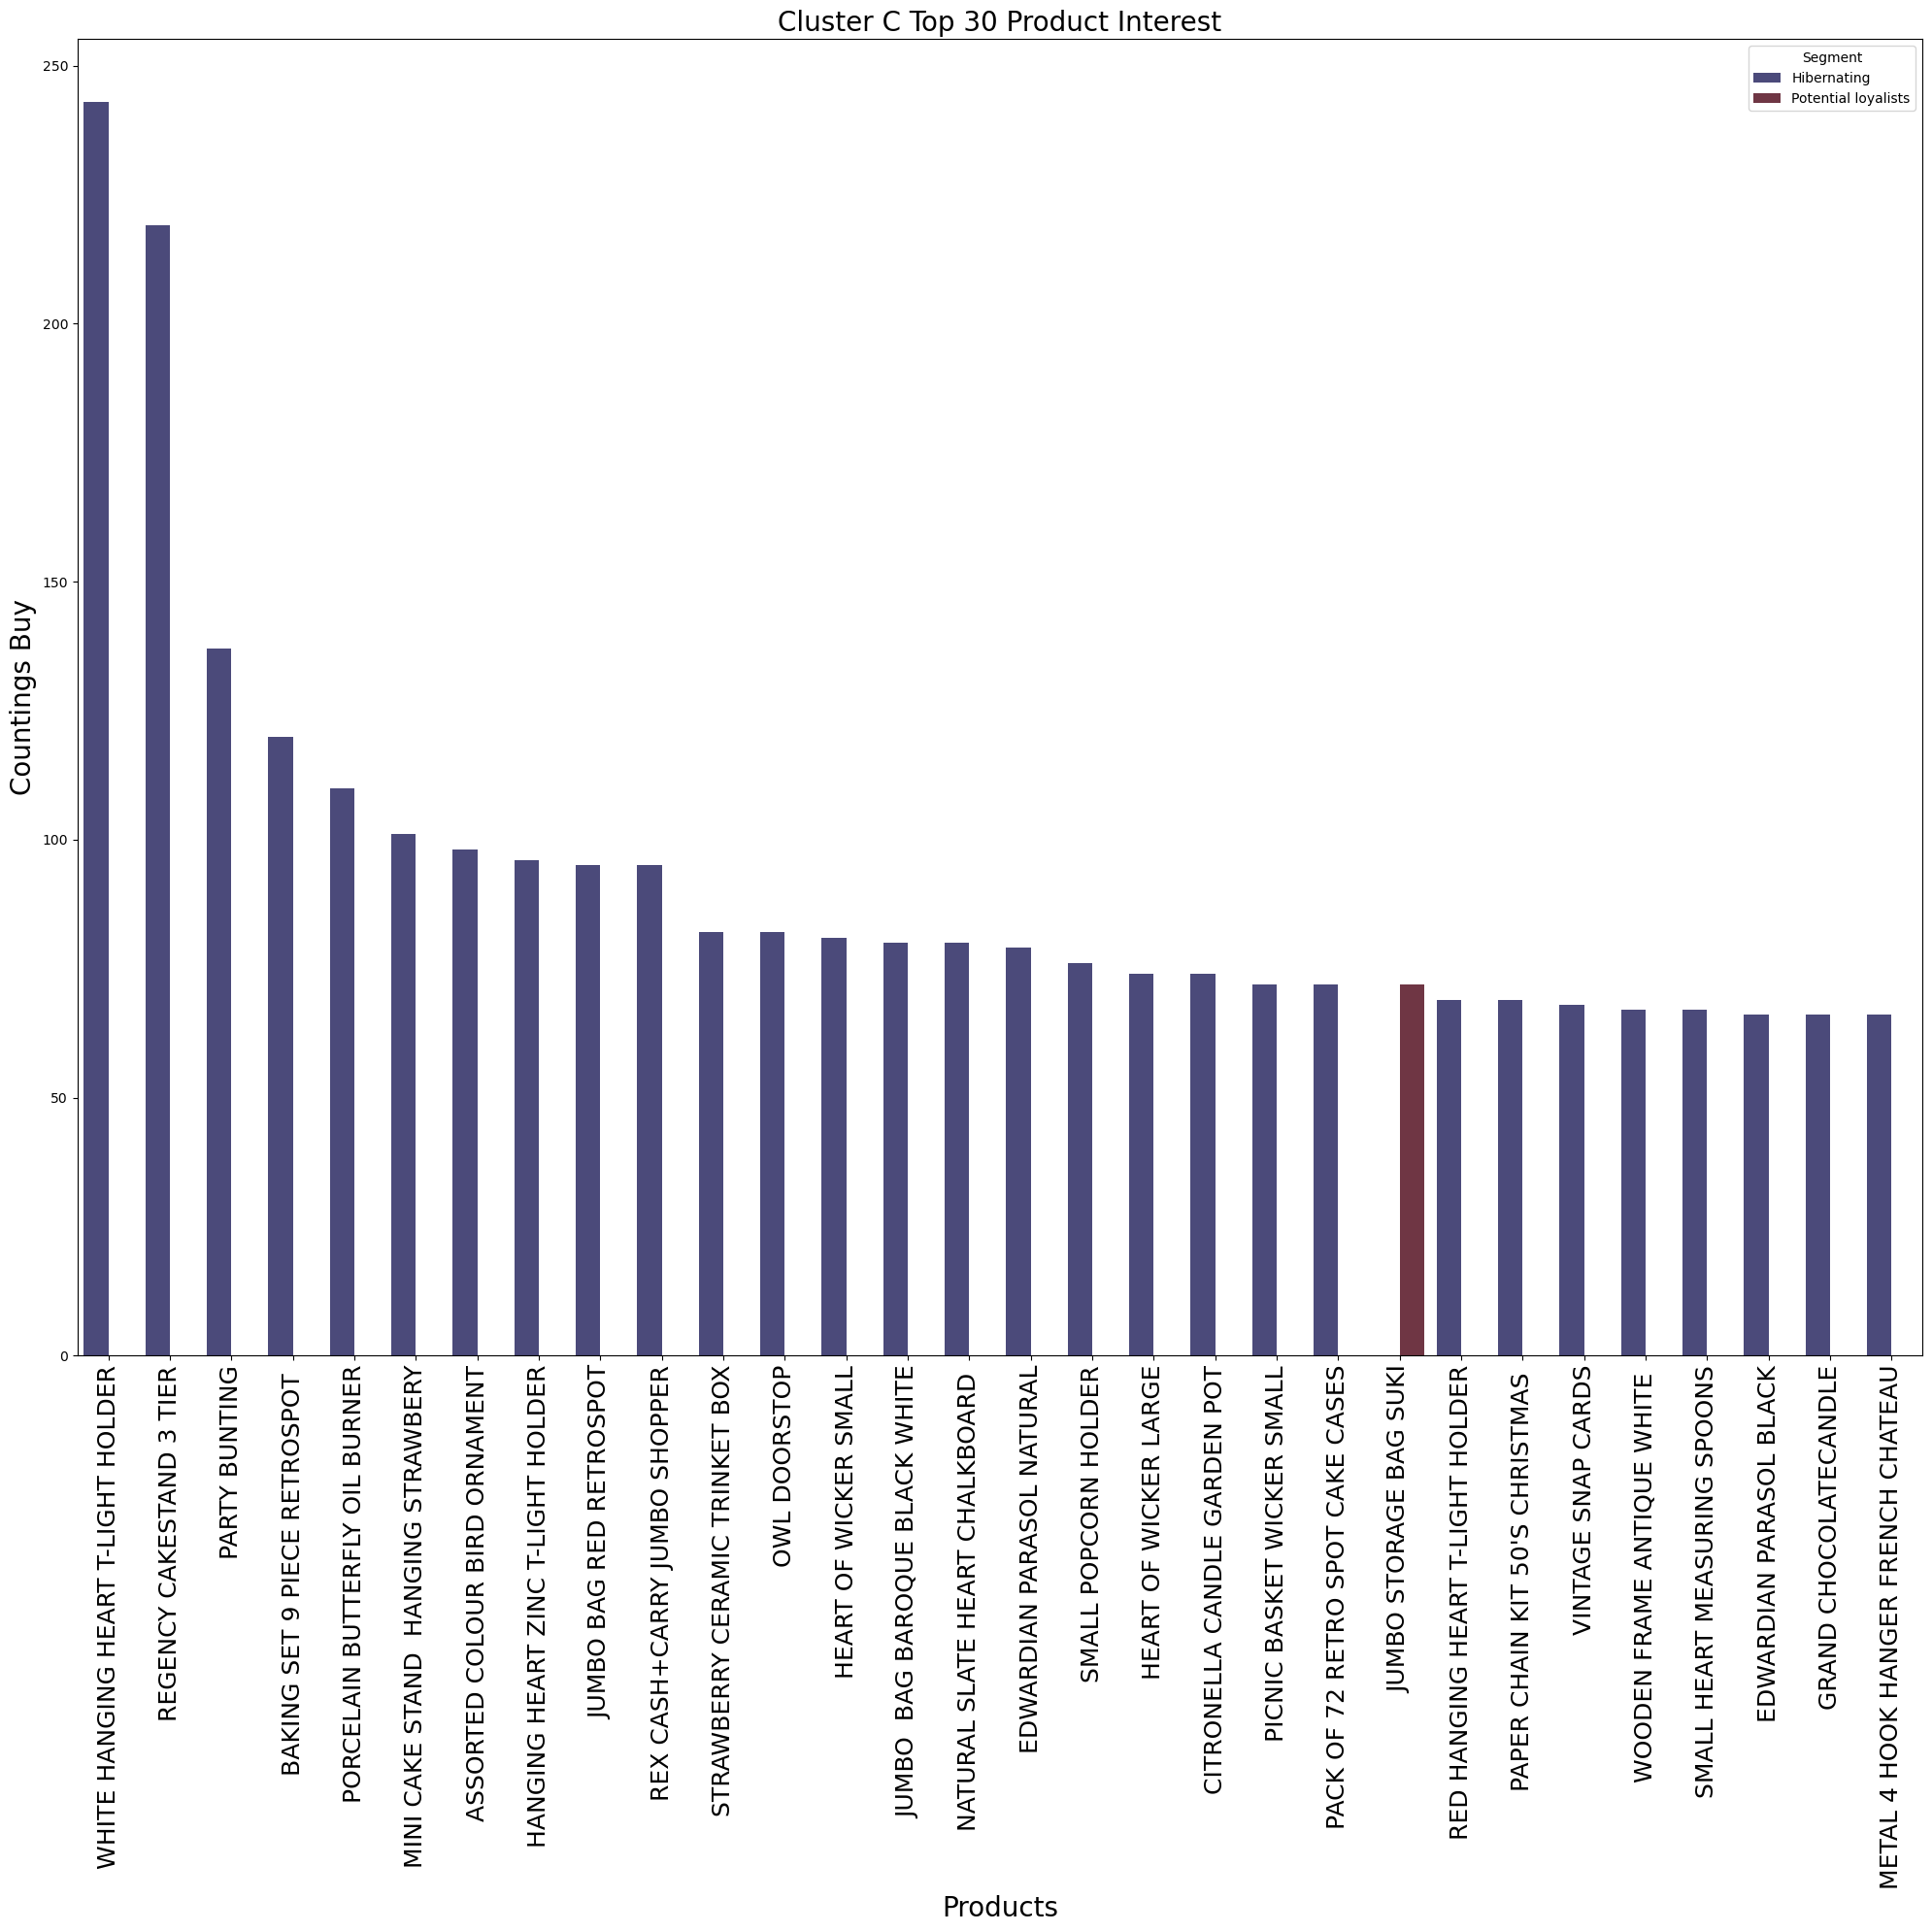

In [36]:
plt.figure(figsize=(20,20))
sns.barplot(x= 'Description', y= 'Invoice',
            data=prod_clus_C, hue='Segment',
            palette = 'icefire',
            ci=None)
plt.xticks(size=18,rotation=90)
plt.xlabel(xlabel='Products',size=20)
plt.ylabel('Countings Buy', size=20)
plt.title('Cluster C Top 30 Product Interest', size=20)
plt.tight_layout()
plt.savefig('Cluster C Top 30 Product Interest.jpeg',
            pil_kwargs={'quality': 95,'papertype':'letter'});

## Cluster D

In [37]:
prod_clus_D = prod_clus[prod_clus['ClusterLog'] == 'Cluster D'][['Segment','Description','Invoice','Country']].head(30)
prod_clus_D

,Segment,Description,Invoice,Country
71421,Champions,WHITE HANGING HEART T-LIGHT HOLDER,2623,United Kingdom
60714,Champions,JUMBO BAG RED RETROSPOT,1714,United Kingdom
66178,Champions,REGENCY CAKESTAND 3 TIER,1681,United Kingdom
53160,Champions,ASSORTED COLOUR BIRD ORNAMENT,1448,United Kingdom
61443,Champions,LUNCH BAG BLACK SKULL.,1384,United Kingdom
60851,Champions,JUMBO STORAGE BAG SUKI,1179,United Kingdom
63684,Champions,PARTY BUNTING,1156,United Kingdom
61478,Champions,LUNCH BAG CARS BLUE,1143,United Kingdom
60830,Champions,JUMBO SHOPPER VINTAGE RED PAISLEY,1141,United Kingdom
61568,Champions,LUNCH BAG SPACEBOY DESIGN,1109,United Kingdom


In [38]:
prod_clus_D['Grouped'] = prod_clus_D.groupby('Invoice')['Description'].transform(lambda x: ','.join(x))
count = Counter()

for row in prod_clus_D['Grouped']:
    row_list = row.split(',')
    count.update(Counter(combinations(row_list, 2)))

count.most_common(10)

[]

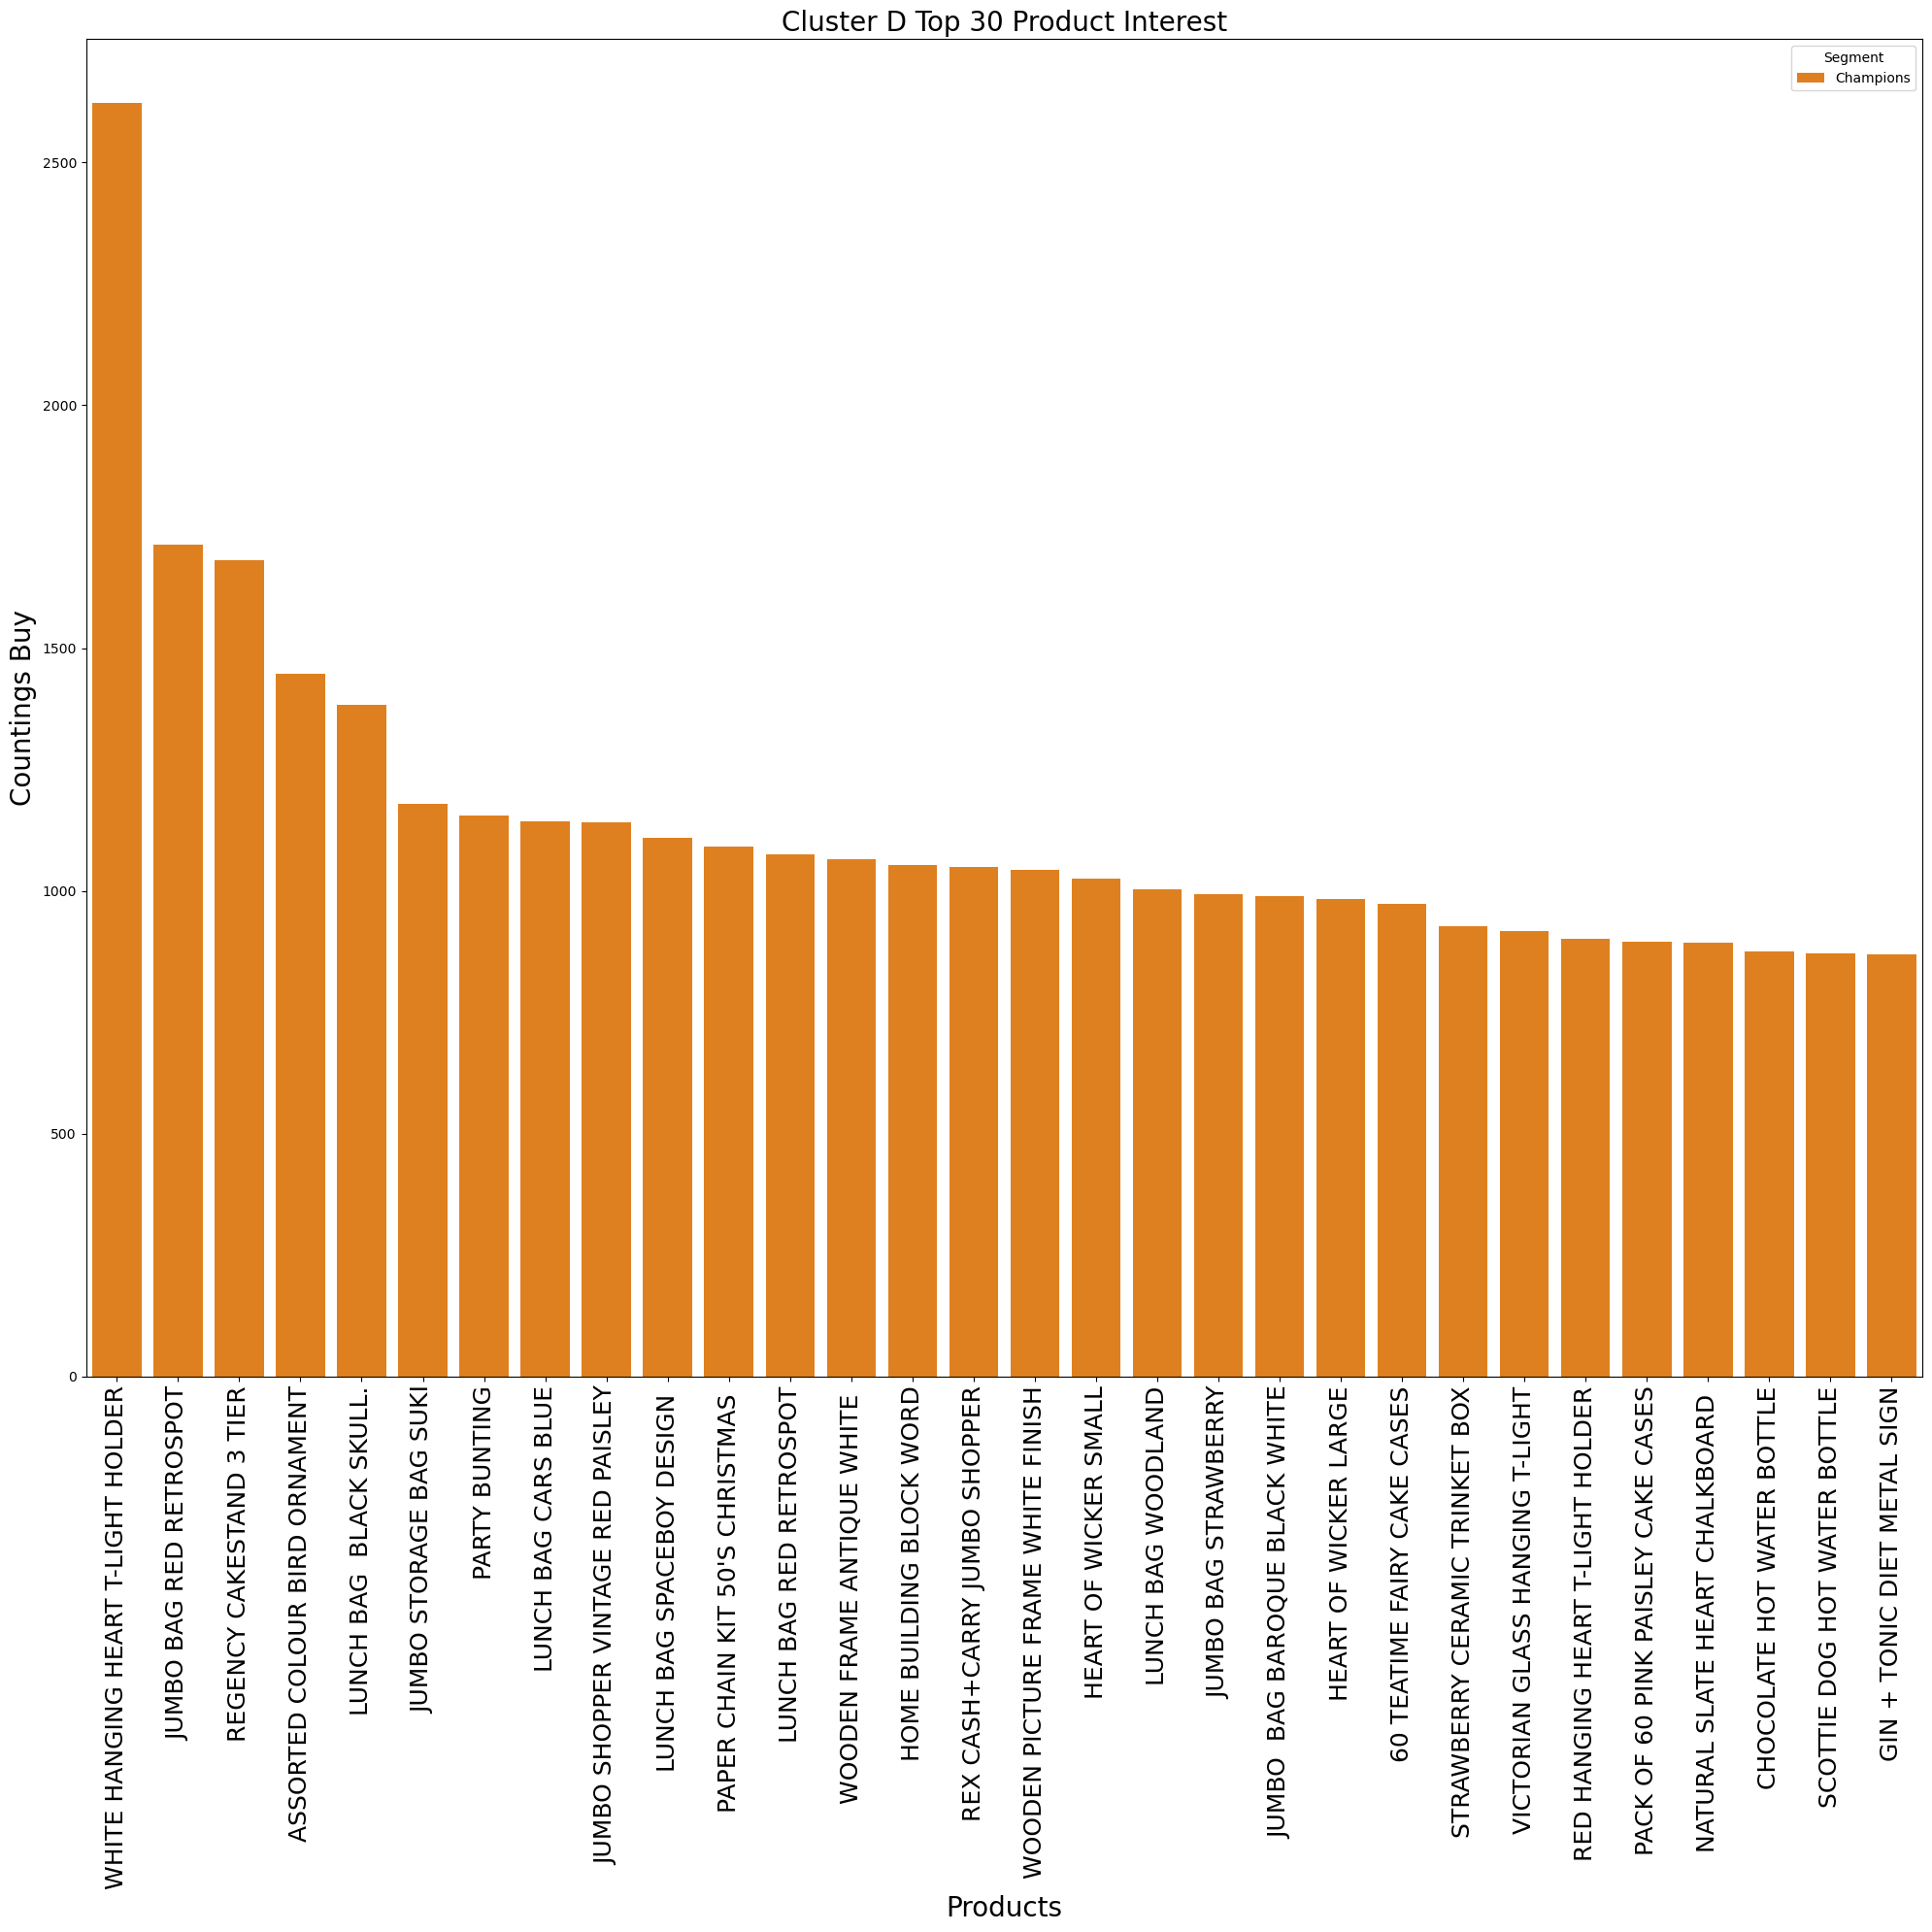

In [39]:
plt.figure(figsize=(20,20))
sns.barplot(x= 'Description', y= 'Invoice',
            data=prod_clus_D, hue='Segment',
            palette = 'autumn',
            ci=None)
plt.xticks(size=18,rotation=90)
plt.xlabel(xlabel='Products',size=20)
plt.ylabel('Countings Buy', size=20)
plt.title('Cluster D Top 30 Product Interest', size=20)
plt.tight_layout()
plt.savefig('Cluster D Top 30 Product Interest.jpeg',
            pil_kwargs={'quality': 95,'papertype':'letter'});

## Cluster E

In [40]:
prod_clus_E = prod_clus[prod_clus['ClusterLog'] == 'Cluster E'][['Segment','Description','Invoice','Country']]
prod_clus_E

,Segment,Description,Invoice,Country
80267,Hibernating,REX CASH+CARRY JUMBO SHOPPER,17,United Kingdom
80244,Hibernating,REGENCY CAKESTAND 3 TIER,13,United Kingdom
79842,Hibernating,JUMBO BAG OWLS,13,United Kingdom
79915,Hibernating,LUNCH BAG BLACK SKULL.,12,United Kingdom
79854,Hibernating,JUMBO SHOPPER VINTAGE RED PAISLEY,12,United Kingdom
...,...,...,...,...
80835,New customers,TRAVEL CARD WALLET TRANSPORT,1,United Kingdom
80458,Hibernating,SKULL LUNCH BOX WITH CUTLERY,1,United Kingdom
79877,Hibernating,LARGE SPOTTY CHOCOLATE GIFT BAG,1,United Kingdom
80837,New customers,VINTAGE CHRISTMAS BUNTING,1,United Kingdom


In [41]:
prod_clus_E['Grouped'] = prod_clus_E.groupby('Invoice')['Description'].transform(lambda x: ','.join(x))

In [42]:
count = Counter()

for row in prod_clus_E['Grouped'].head(100):
    row_list = row.split(',')
    count.update(Counter(combinations(row_list, 2)))

count.most_common(10)

[(('SET/3 VANILLA SCENTED CANDLE IN BOX', 'SET/6 RED SPOTTY PAPER CUPS'), 36),
 (('SET/3 VANILLA SCENTED CANDLE IN BOX', 'RECYCLING BAG RETROSPOT '), 36),
 (('SET/3 VANILLA SCENTED CANDLE IN BOX', 'RED ORGANIC CANDLE IN GLASS'), 36),
 (('SET/3 VANILLA SCENTED CANDLE IN BOX', 'SKULLS  WATER TRANSFER TATTOOS '),
  36),
 (('SET/3 VANILLA SCENTED CANDLE IN BOX',
   'SILVER/CRYSTAL DROP EARRINGS W LEAF'),
  36),
 (('SET/3 VANILLA SCENTED CANDLE IN BOX', 'SCOTTIE DOG HOT WATER BOTTLE'), 36),
 (('SET/3 VANILLA SCENTED CANDLE IN BOX', 'SET 12 PEAR BOTANICAL T-LIGHTS'),
  36),
 (('SET/3 VANILLA SCENTED CANDLE IN BOX', 'SET OF 12 LILY BOTANICAL T-LIGHTS'),
  36),
 (('SET/3 VANILLA SCENTED CANDLE IN BOX', 'RETRO SPOT TEA SET CERAMIC 11 PC '),
  36),
 (('SET/3 VANILLA SCENTED CANDLE IN BOX', 'SET 7 BABUSHKA NESTING BOXES'), 36)]

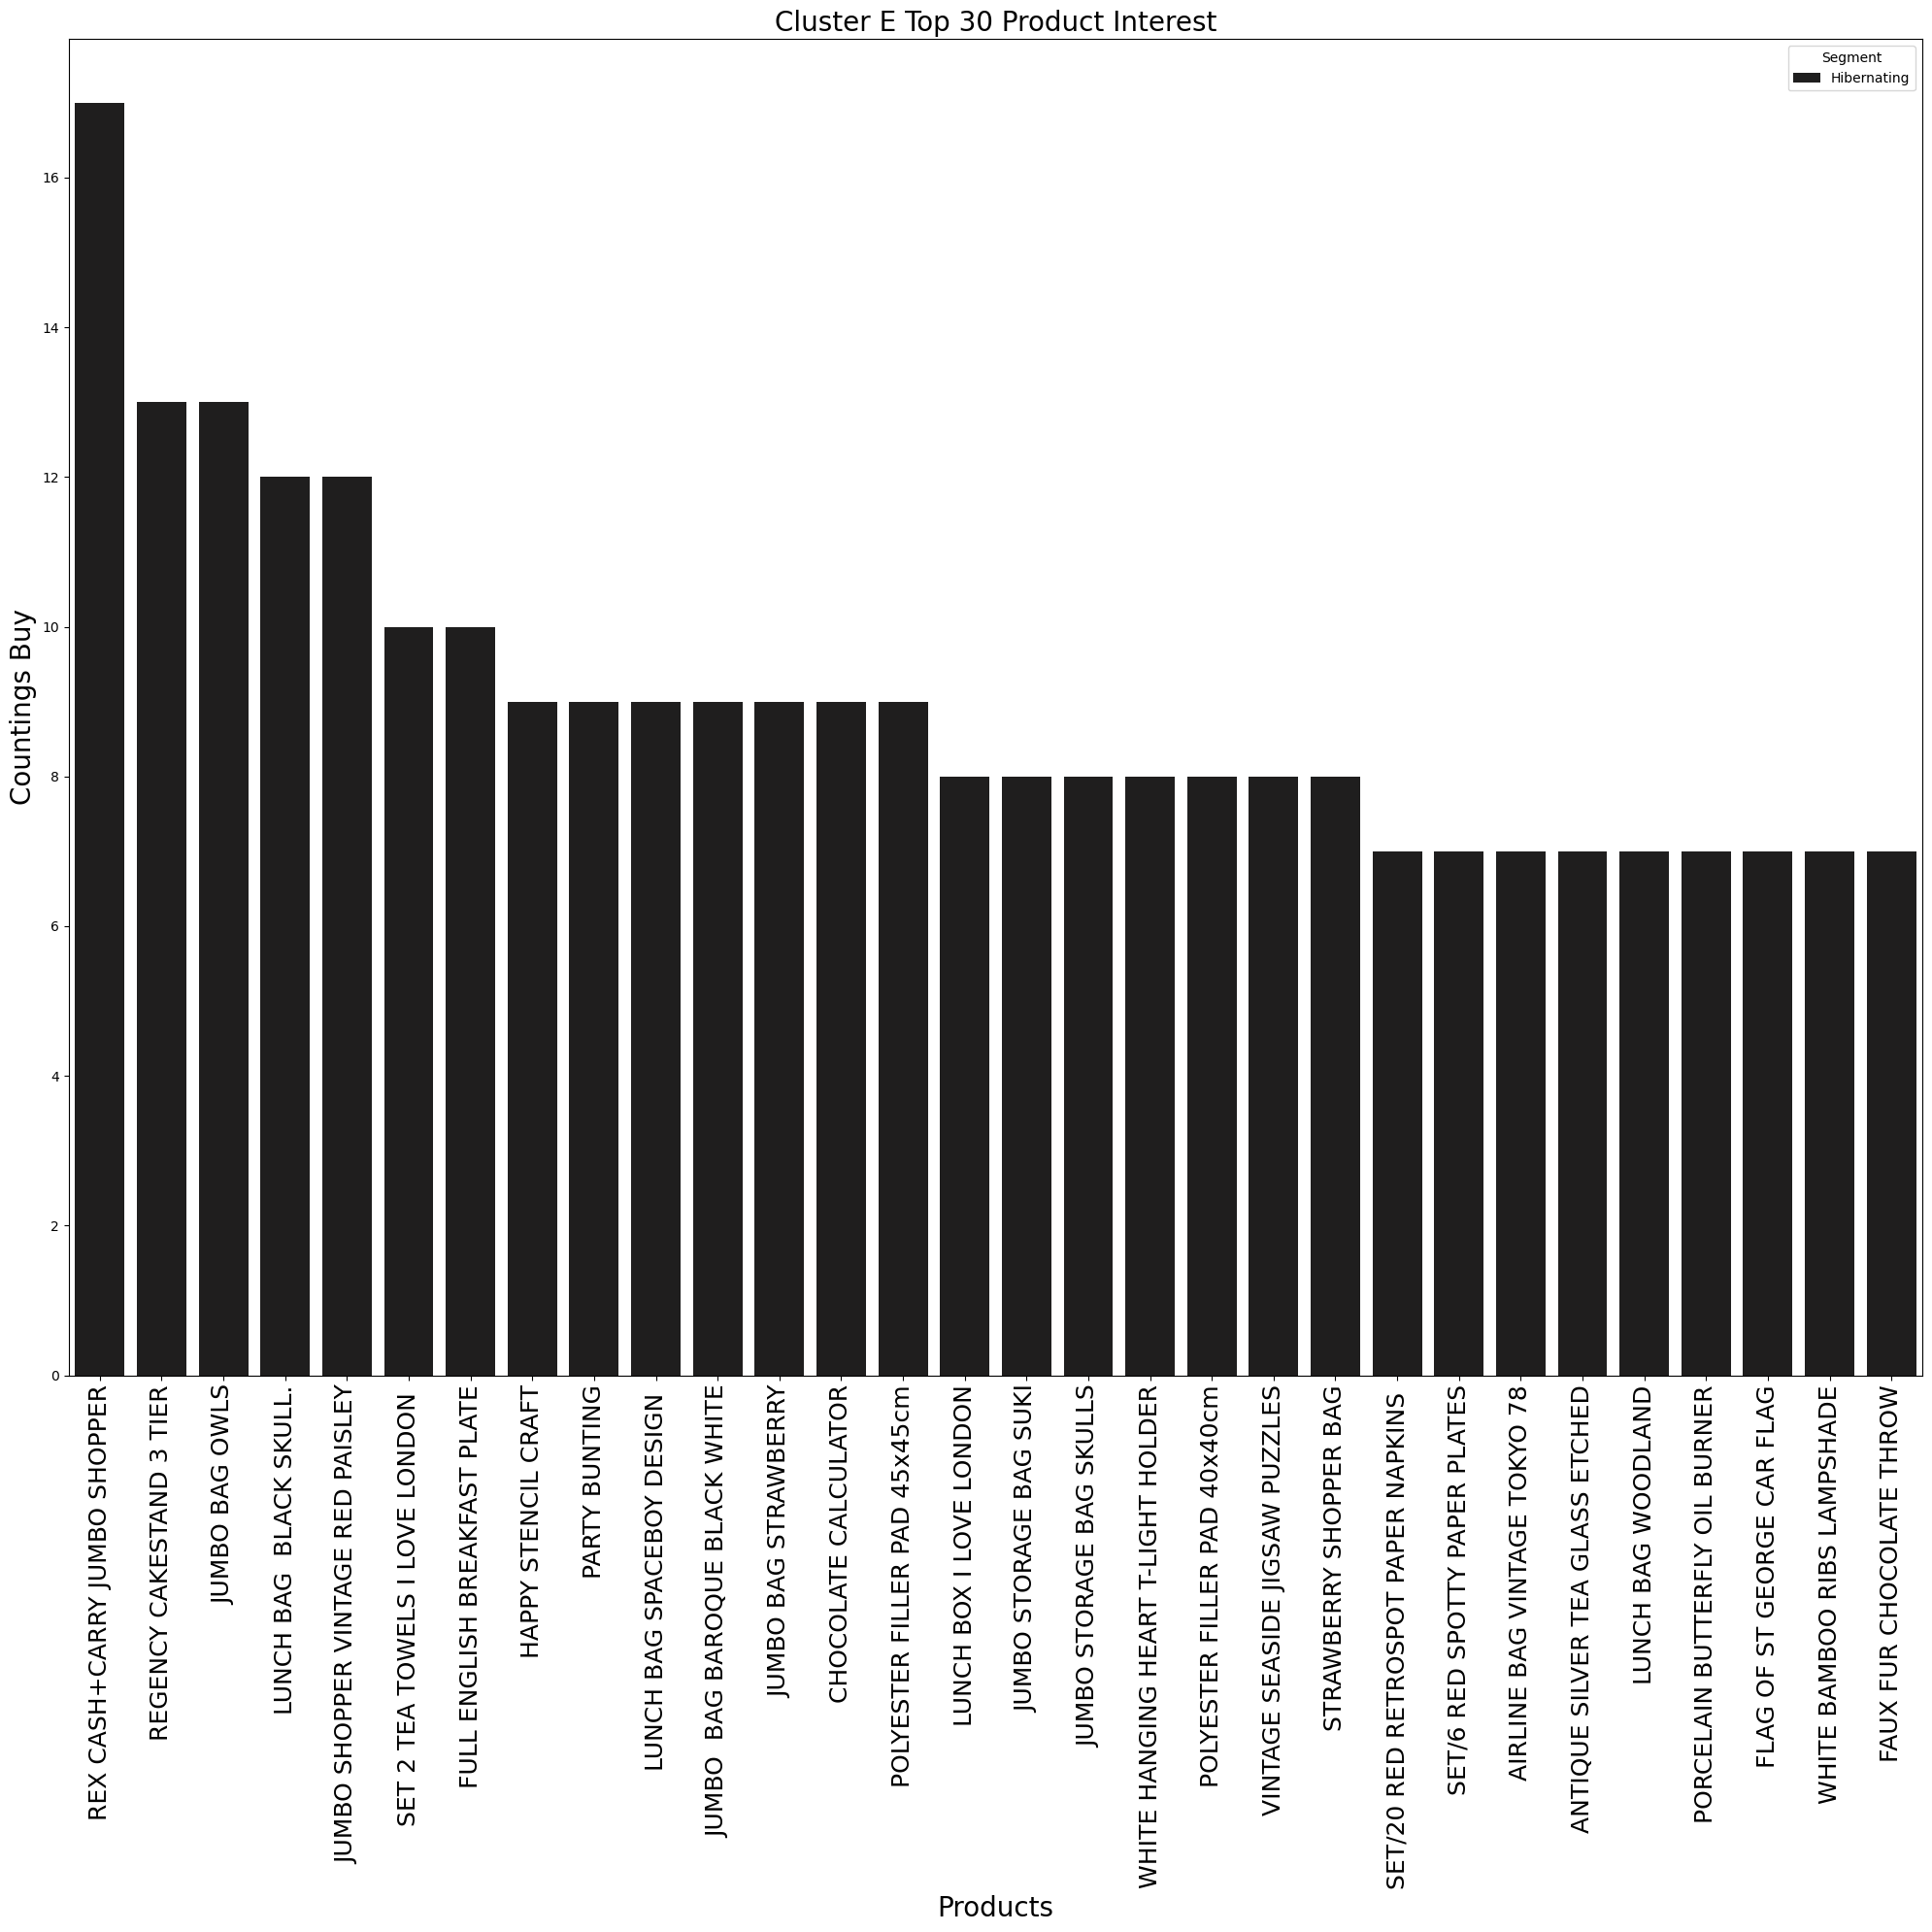

In [43]:
plt.figure(figsize=(20,20))
sns.barplot(x= 'Description', y= 'Invoice',
            data = prod_clus_E.head(30), hue='Segment',
            palette = 'icefire_r',
            ci=None)
plt.xticks(size=18,rotation=90)
plt.xlabel(xlabel='Products',size=20)
plt.ylabel('Countings Buy', size=20)
plt.title('Cluster E Top 30 Product Interest', size=20)
plt.tight_layout()
plt.savefig('Cluster E Top 30 Product Interest.jpeg',
            pil_kwargs={'quality': 95,'papertype':'letter'});

# **Product Month Cluster**

In [44]:
prod_clus_mth = df.groupby(['ClusterLog','Segment','Description', 'Month'], observed=True, as_index=False).agg({'Invoice': lambda x : len(x),
                                                                                                 'Amount': lambda x : x.sum()})

In [45]:
prod_clus_mth

,ClusterLog,Segment,Description,Month,Invoice,Amount
0,Cluster A,At risk,DOORMAT UNION JACK GUNS AND ROSES,Jan,3,79.75
1,Cluster A,At risk,DOORMAT UNION JACK GUNS AND ROSES,Mar,1,13.50
2,Cluster A,At risk,3 STRIPEY MICE FELTCRAFT,Jan,2,23.40
3,Cluster A,At risk,3 STRIPEY MICE FELTCRAFT,Feb,2,23.40
4,Cluster A,At risk,3 STRIPEY MICE FELTCRAFT,Mar,1,11.70
...,...,...,...,...,...,...
195552,Cluster E,Promising,WRAP I LOVE LONDON,Sep,1,10.50
195553,Cluster E,Promising,WRAP MONSTER FUN,Jun,1,1.26
195554,Cluster E,Promising,WRAP RED APPLES,Jun,1,1.26
195555,Cluster E,Promising,WRAP RED DOILEY,Jul,1,2.10


## Cluster A

In [46]:
prod_clus_mth_A = prod_clus_mth[prod_clus_mth['ClusterLog'] == 'Cluster A'].sort_values(by='Invoice', ascending=False)
prod_clus_mth_A.head(30)

,ClusterLog,Segment,Description,Month,Invoice,Amount
44665,Cluster A,Can't loose them,WHITE HANGING HEART T-LIGHT HOLDER,Dec,116,4272.84
39480,Cluster A,Can't loose them,SCOTTIE DOG HOT WATER BOTTLE,Dec,98,3604.95
75047,Cluster A,Loyal customers,WHITE HANGING HEART T-LIGHT HOLDER,May,87,2436.23
44654,Cluster A,Can't loose them,WHITE HANGING HEART T-LIGHT HOLDER,Jan,82,1813.43
75049,Cluster A,Loyal customers,WHITE HANGING HEART T-LIGHT HOLDER,Jul,80,2486.84
75050,Cluster A,Loyal customers,WHITE HANGING HEART T-LIGHT HOLDER,Aug,80,2727.63
31216,Cluster A,Can't loose them,KNITTED UNION FLAG HOT WATER BOTTLE,Dec,80,4429.59
44656,Cluster A,Can't loose them,WHITE HANGING HEART T-LIGHT HOLDER,Mar,78,1476.73
65045,Cluster A,Loyal customers,PARTY BUNTING,May,77,7428.65
61040,Cluster A,Loyal customers,JUMBO BAG RED RETROSPOT,Sep,76,2417.01


In [90]:
prod_clus_mth_A['Description'][:20].values.tolist()

['WHITE HANGING HEART T-LIGHT HOLDER',
 'SCOTTIE DOG HOT WATER BOTTLE',
 'WHITE HANGING HEART T-LIGHT HOLDER',
 'WHITE HANGING HEART T-LIGHT HOLDER',
 'WHITE HANGING HEART T-LIGHT HOLDER',
 'WHITE HANGING HEART T-LIGHT HOLDER',
 'KNITTED UNION FLAG HOT WATER BOTTLE',
 'WHITE HANGING HEART T-LIGHT HOLDER',
 'PARTY BUNTING',
 'JUMBO BAG RED RETROSPOT',
 "PAPER CHAIN KIT 50'S CHRISTMAS ",
 'REGENCY CAKESTAND 3 TIER',
 'WHITE HANGING HEART T-LIGHT HOLDER',
 'CHOCOLATE HOT WATER BOTTLE',
 'METAL SIGN,CUPCAKE SINGLE HOOK',
 'PARTY BUNTING',
 'WHITE HANGING HEART T-LIGHT HOLDER',
 'WHITE SKULL HOT WATER BOTTLE ',
 'RED WOOLLY HOTTIE WHITE HEART.',
 'STRAWBERRY CERAMIC TRINKET BOX']

In [47]:
prod_clus_mth_A['Grouped'] = prod_clus_mth_A.groupby('Invoice')['Description'].transform(lambda x: ','.join(x))

In [48]:
count = Counter()

for row in prod_clus_mth_A['Grouped'].head(500):
    row_list = row.split(',')
    count.update(Counter(combinations(row_list, 2)))

count.most_common(10)

[(('ASSORTED COLOURS SILK FAN', 'VICTORIAN GLASS HANGING T-LIGHT'), 420),
 (('CHOCOLATE HOT WATER BOTTLE', 'VICTORIAN GLASS HANGING T-LIGHT'), 360),
 (('ASSORTED COLOURS SILK FAN', 'WOODEN PICTURE FRAME WHITE FINISH'), 360),
 (('JUMBO STORAGE BAG SUKI', 'ASSORTED COLOURS SILK FAN'), 300),
 (('JUMBO STORAGE BAG SUKI', 'VICTORIAN GLASS HANGING T-LIGHT'), 300),
 (('CHOCOLATE HOT WATER BOTTLE', 'ASSORTED COLOURS SILK FAN'), 300),
 (('ASSORTED COLOURS SILK FAN', 'HEART OF WICKER SMALL'), 300),
 (('GREEN REGENCY TEACUP AND SAUCER', 'VICTORIAN GLASS HANGING T-LIGHT'), 300),
 (('JUMBO BAG PINK VINTAGE PAISLEY', 'VICTORIAN GLASS HANGING T-LIGHT'), 300),
 (('WHITE HANGING HEART T-LIGHT HOLDER', 'STRAWBERRY CERAMIC TRINKET BOX'),
  286)]

In [49]:
mpl.rcParams.update(mpl.rcParamsDefault)

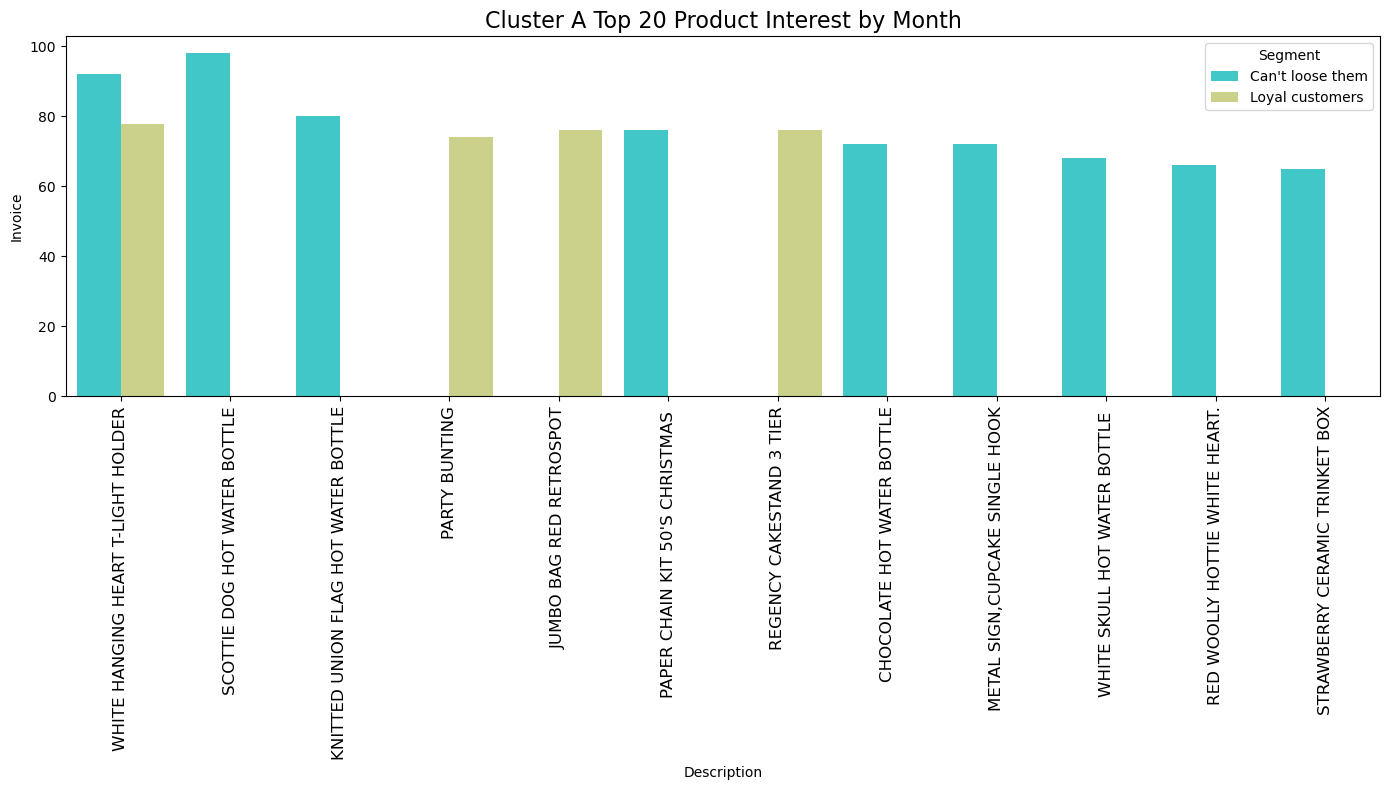

In [50]:
plt.figure(figsize=(14,8))
sns.barplot(x= 'Description', y= 'Invoice',
            data=prod_clus_mth_A.head(20), hue='Segment',
            palette = 'rainbow',
            ci=None)

plt.xticks(size=12,rotation=90)
plt.title('Cluster A Top 20 Product Interest by Month', size=16)
plt.tight_layout()
plt.savefig('Cluster A Top 20 Product Interest by Month.jpeg',
            pil_kwargs={'quality': 95,'papertype':'letter'});

## Cluster B

In [51]:
prod_clus_mth_B = prod_clus_mth[prod_clus_mth['ClusterLog'] == 'Cluster B'].sort_values(by='Invoice', ascending=False).head(50)
prod_clus_mth_B

,ClusterLog,Segment,Description,Month,Invoice,Amount
87076,Cluster B,Champions,RABBIT NIGHT LIGHT,Nov,71,1180.25
86025,Cluster B,Champions,PAPER CHAIN KIT 50'S CHRISTMAS,Nov,67,1103.30
78701,Cluster B,Champions,ASSORTED COLOUR BIRD ORNAMENT,Nov,56,1074.84
87881,Cluster B,Champions,REX CASH+CARRY JUMBO SHOPPER,Nov,56,95.95
91407,Cluster B,Champions,WOODEN HEART CHRISTMAS SCANDINAVIAN,Nov,54,258.83
91461,Cluster B,Champions,WOODEN STAR CHRISTMAS SCANDINAVIAN,Nov,54,219.22
91143,Cluster B,Champions,WHITE HANGING HEART T-LIGHT HOLDER,Nov,54,1075.21
82582,Cluster B,Champions,GARDENERS KNEELING PAD KEEP CALM,Nov,45,402.53
86068,Cluster B,Champions,PAPER CHAIN KIT VINTAGE CHRISTMAS,Nov,44,777.55
83144,Cluster B,Champions,HAND WARMER BIRD DESIGN,Nov,43,556.50


In [52]:
prod_clus_mth_B['Grouped'] = prod_clus_mth_B.groupby('Invoice')['Description'].transform(lambda x: ','.join(x))
count = Counter()

for row in prod_clus_mth_B['Grouped']:
    row_list = row.split(',')
    count.update(Counter(combinations(row_list, 2)))

count.most_common(10)

[(('LARGE WHITE HEART OF WICKER', 'WOODEN TREE CHRISTMAS SCANDINAVIAN'), 8),
 (('LARGE WHITE HEART OF WICKER', 'SCOTTIE DOG HOT WATER BOTTLE'), 8),
 (('LARGE WHITE HEART OF WICKER', "BOX OF 6 MINI 50'S CRACKERS"), 8),
 (('LARGE WHITE HEART OF WICKER', '60 CAKE CASES VINTAGE CHRISTMAS'), 8),
 (('LARGE WHITE HEART OF WICKER', "PAPER CHAIN KIT 50'S CHRISTMAS "), 8),
 (('LARGE WHITE HEART OF WICKER', 'HAND WARMER RED RETROSPOT'), 8),
 (('LARGE WHITE HEART OF WICKER', 'REX CASH+CARRY JUMBO SHOPPER'), 8),
 (('WOODEN TREE CHRISTMAS SCANDINAVIAN', 'SCOTTIE DOG HOT WATER BOTTLE'), 8),
 (('WOODEN TREE CHRISTMAS SCANDINAVIAN', "BOX OF 6 MINI 50'S CRACKERS"), 8),
 (('WOODEN TREE CHRISTMAS SCANDINAVIAN', '60 CAKE CASES VINTAGE CHRISTMAS'),
  8)]

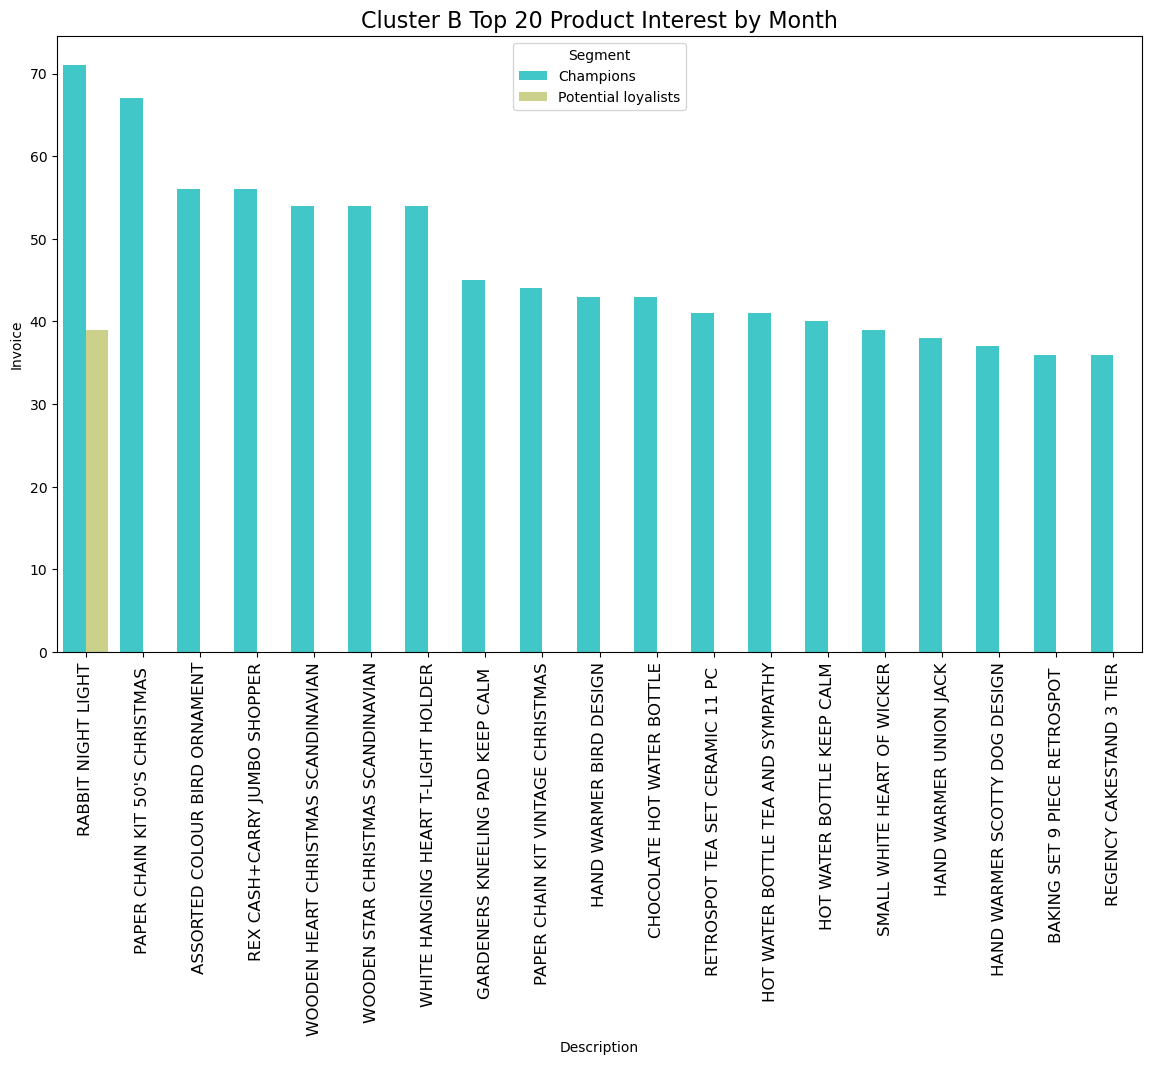

In [53]:
plt.figure(figsize=(14,8))
sns.barplot(x= 'Description', y= 'Invoice',
            data=prod_clus_mth_B.head(20), hue='Segment',
            palette = 'rainbow',
            ci=None)

plt.xticks(size=12, rotation=90)
plt.title('Cluster B Top 20 Product Interest by Month', size=16)
plt.savefig('Cluster B Top 20 Product Interest by Month.jpeg',
            pil_kwargs={'quality': 95,'papertype':'letter'});

## Cluster C

In [54]:
prod_clus_mth_C = prod_clus_mth[prod_clus_mth['ClusterLog'] == 'Cluster C'].sort_values(by='Invoice', ascending=False).head(50)
prod_clus_mth_C

,ClusterLog,Segment,Description,Month,Invoice,Amount
123057,Cluster C,Hibernating,PARTY BUNTING,Apr,41,1297.00
124940,Cluster C,Hibernating,REGENCY CAKESTAND 3 TIER,Apr,35,1494.45
128710,Cluster C,Hibernating,WHITE HANGING HEART T-LIGHT HOLDER,Dec,34,1284.10
132183,Cluster C,Potential loyalists,JUMBO STORAGE BAG SUKI,Jun,33,545.31
123058,Cluster C,Hibernating,PARTY BUNTING,May,32,810.56
124943,Cluster C,Hibernating,REGENCY CAKESTAND 3 TIER,Jul,32,1223.65
122992,Cluster C,Hibernating,PAPER CHAIN KIT 50'S CHRISTMAS,Dec,32,701.51
124942,Cluster C,Hibernating,REGENCY CAKESTAND 3 TIER,Jun,30,1427.66
132171,Cluster C,Potential loyalists,JUMBO SHOPPER VINTAGE RED PAISLEY,Jun,29,433.65
128976,Cluster C,Hibernating,WOODEN BOX ADVENT CALENDAR,Oct,28,928.58


In [55]:
prod_clus_mth_C['Grouped'] = prod_clus_mth_C.groupby('Invoice')['Description'].transform(lambda x: ','.join(x))
count = Counter()

for row in prod_clus_mth_C['Grouped']:
    row_list = row.split(',')
    count.update(Counter(combinations(row_list, 2)))

count.most_common(10)

[(('PORCELAIN BUTTERFLY OIL BURNER', 'WHITE HANGING HEART T-LIGHT HOLDER'),
  16),
 (('BINGO SET', 'WHITE HANGING HEART T-LIGHT HOLDER'), 16),
 (('VINTAGE UNION JACK BUNTING', 'WHITE HANGING HEART T-LIGHT HOLDER'), 16),
 (('WHITE HANGING HEART T-LIGHT HOLDER', 'HANGING HEART JAR T-LIGHT HOLDER'),
  16),
 (('WHITE HANGING HEART T-LIGHT HOLDER', 'WHITE HANGING HEART T-LIGHT HOLDER'),
  12),
 (('SCOTTIE DOG HOT WATER BOTTLE', 'REGENCY CAKESTAND 3 TIER'), 10),
 (('JUMBO BAG PINK POLKADOT', 'REGENCY CAKESTAND 3 TIER'), 10),
 (('JUMBO BAG PINK VINTAGE PAISLEY', 'REGENCY CAKESTAND 3 TIER'), 10),
 (('PORCELAIN BUTTERFLY OIL BURNER', 'BINGO SET'), 8),
 (('PORCELAIN BUTTERFLY OIL BURNER', 'VINTAGE UNION JACK BUNTING'), 8)]

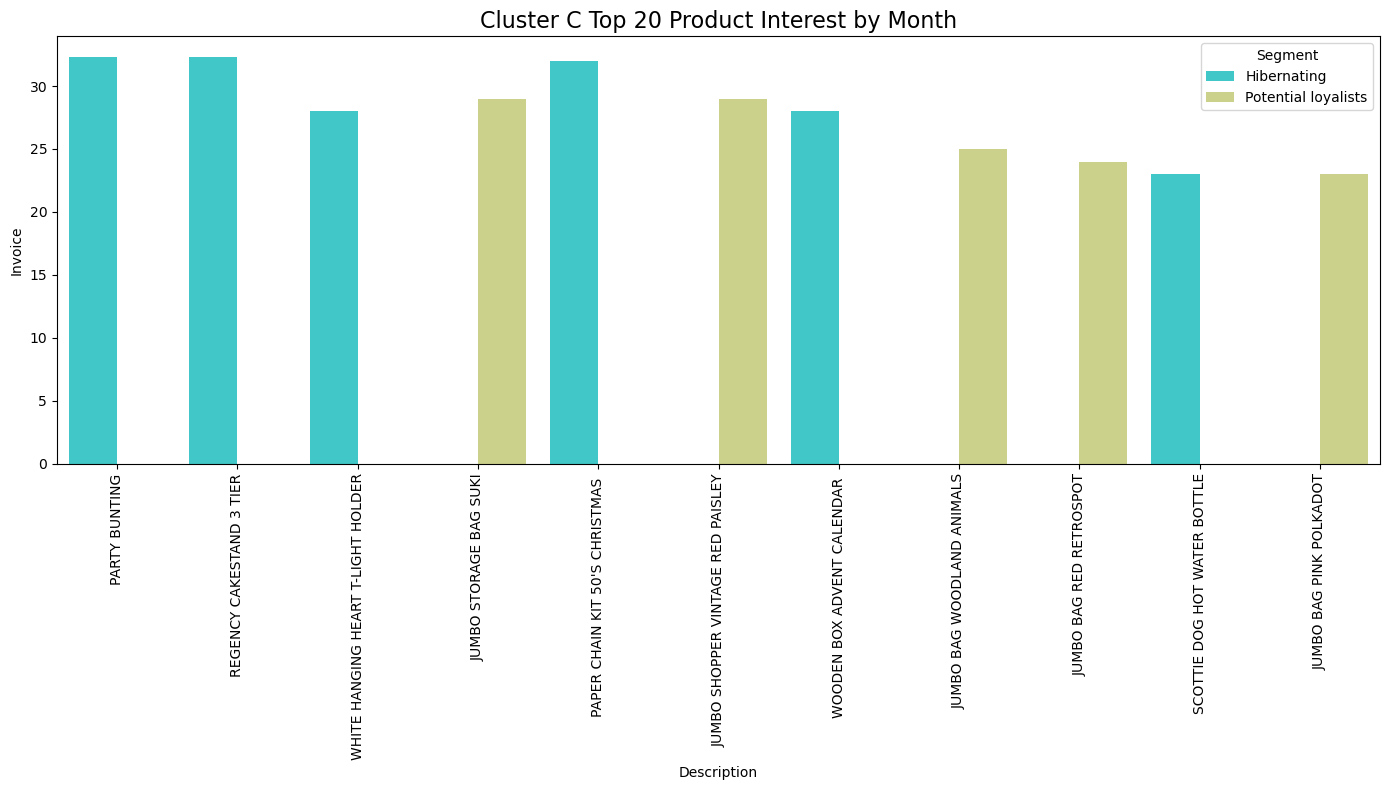

In [56]:
plt.figure(figsize=(14,8))
sns.barplot(x= 'Description', y= 'Invoice',
            data=prod_clus_mth_C.head(20), hue='Segment',
            palette = 'rainbow',
            ci=None)

plt.xticks(rotation=90)
plt.title('Cluster C Top 20 Product Interest by Month', size=16)
plt.tight_layout()
plt.savefig('Cluster C Top 20 Product Interest by Month.jpeg',
            pil_kwargs={'quality': 95,'papertype':'letter'});

## Cluster D

In [57]:
prod_clus_mth_D = prod_clus_mth[prod_clus_mth['ClusterLog'] == 'Cluster D'].sort_values(by='Invoice', ascending=False)
display(prod_clus_mth_D.head(5), prod_clus_mth_D.shape, prod_clus_mth_D.isna().sum())

,ClusterLog,Segment,Description,Month,Invoice,Amount
158192,Cluster D,Champions,PAPER CHAIN KIT 50'S CHRISTMAS,Nov,483,33055.99
172361,Cluster D,Champions,WHITE HANGING HEART T-LIGHT HOLDER,Nov,410,24234.58
151082,Cluster D,Champions,HAND WARMER OWL DESIGN,Nov,387,11176.81
161399,Cluster D,Champions,RABBIT NIGHT LIGHT,Nov,382,27869.67
158259,Cluster D,Champions,PAPER CHAIN KIT VINTAGE CHRISTMAS,Nov,373,17805.69


(57253, 6)

ClusterLog     0
Segment        0
Description    0
Month          0
Invoice        0
Amount         0
dtype: int64

In [58]:
prod_clus_mth_D['Grouped'] = prod_clus_mth_D.groupby('Invoice')['Description'].transform(lambda x: ','.join(x))

In [59]:

count = Counter()

for row in prod_clus_mth_D['Grouped'].head(3000):
    row_list = row.split(',')
    count.update(Counter(combinations(row_list, 2)))

count.most_common(10)

[(('RED SPOT CERAMIC DRAWER KNOB', 'JUMBO BAG WOODLAND ANIMALS'), 666),
 (('ENAMEL BREAD BIN CREAM', 'JUMBO BAG WOODLAND ANIMALS'), 652),
 (('VINTAGE UNION JACK BUNTING', 'EDWARDIAN PARASOL NATURAL'), 646),
 (('PACK OF 72 RETROSPOT CAKE CASES', 'EDWARDIAN PARASOL NATURAL'), 618),
 (('72 SWEETHEART FAIRY CAKE CASES', 'SET/6 RED SPOTTY PAPER PLATES'), 616),
 (('ZINC METAL HEART DECORATION', 'GARDENERS KNEELING PAD CUP OF TEA '), 588),
 (("YOU'RE CONFUSING ME METAL SIGN ", 'KEY FOB '), 582),
 (('RETROSPOT TEA SET CERAMIC 11 PC ', 'EDWARDIAN PARASOL NATURAL'), 578),
 (('FOUR HOOK  WHITE LOVEBIRDS', 'KEY FOB '), 568),
 (('PACK OF 60 MUSHROOM CAKE CASES', 'SET OF 3 BUTTERFLY COOKIE CUTTERS'),
  566)]

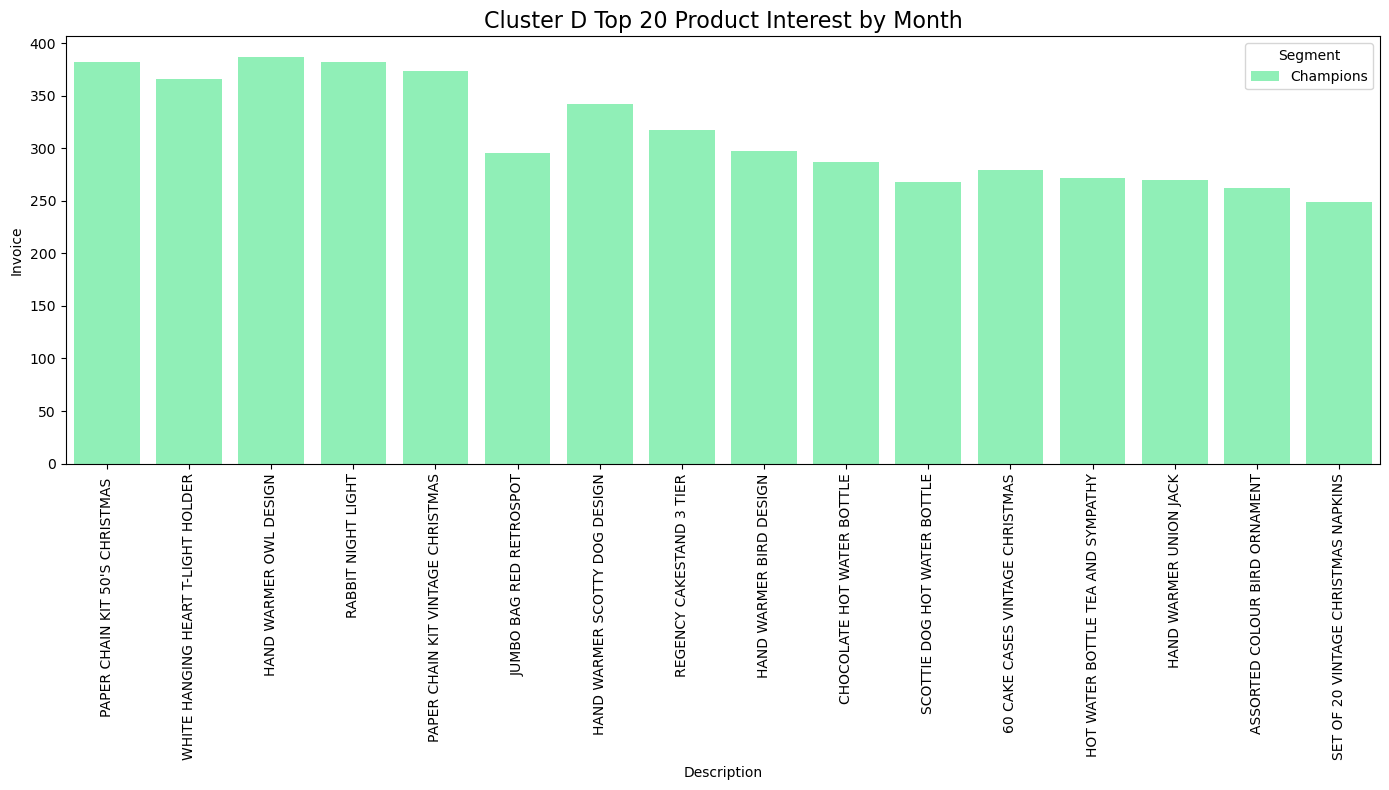

In [60]:
plt.figure(figsize=(14,8))
sns.barplot(x= 'Description', y= 'Invoice',
            data=prod_clus_mth_D.head(20), hue='Segment',
            palette = 'rainbow',
            ci=None)

plt.xticks(rotation=90)
plt.title('Cluster D Top 20 Product Interest by Month', size=16)
plt.tight_layout()
plt.savefig('Cluster D Top 20 Product Interest by Month.jpeg',
            pil_kwargs={'quality': 95,'papertype':'letter'});

## Cluster E

In [61]:
prod_clus_mth_E = prod_clus_mth[prod_clus_mth['ClusterLog'] == 'Cluster E'].sort_values(by='Invoice', ascending=False)
display(prod_clus_mth_E.head(4), len(prod_clus_mth_E))

,ClusterLog,Segment,Description,Month,Invoice,Amount
194473,Cluster E,Hibernating,SET/6 RED SPOTTY PAPER PLATES,Dec,6,25.50
192575,Cluster E,Hibernating,12 COLOURED PARTY BALLOONS,Jun,5,4.55
193704,Cluster E,Hibernating,LUNCH BOX I LOVE LONDON,Oct,5,13.65
194173,Cluster E,Hibernating,REGENCY CAKESTAND 3 TIER,Apr,5,101.98


2994

In [62]:
prod_clus_mth_E['Grouped'] = prod_clus_mth_E.groupby('Invoice')['Description'].transform(lambda x: ','.join(x))

In [63]:
count = Counter()

for row in prod_clus_mth_E['Grouped'].head(100):
    row_list = row.split(',')
    count.update(Counter(combinations(row_list, 2)))

count.most_common(10)

[(('LUNCH BAG  BLACK SKULL.', 'REX CASH+CARRY JUMBO SHOPPER'), 768),
 (('JUMBO SHOPPER VINTAGE RED PAISLEY', 'REX CASH+CARRY JUMBO SHOPPER'), 624),
 (('LUNCH BAG  BLACK SKULL.', 'WHITE HANGING HEART T-LIGHT HOLDER'), 540),
 (('LUNCH BAG  BLACK SKULL.', 'POLYESTER FILLER PAD 40x40cm'), 540),
 (('PARTY BUNTING', 'LUNCH BAG  BLACK SKULL.'), 504),
 (('LUNCH BAG  BLACK SKULL.', 'JUMBO BAG OWLS'), 456),
 (('PARTY BUNTING', 'REX CASH+CARRY JUMBO SHOPPER'), 432),
 (('FLAG OF ST GEORGE CAR FLAG', 'LUNCH BAG  BLACK SKULL.'), 432),
 (('FLAG OF ST GEORGE CAR FLAG', 'REX CASH+CARRY JUMBO SHOPPER'), 432),
 (('BLACK TEA TOWEL CLASSIC DESIGN', 'REX CASH+CARRY JUMBO SHOPPER'), 432)]

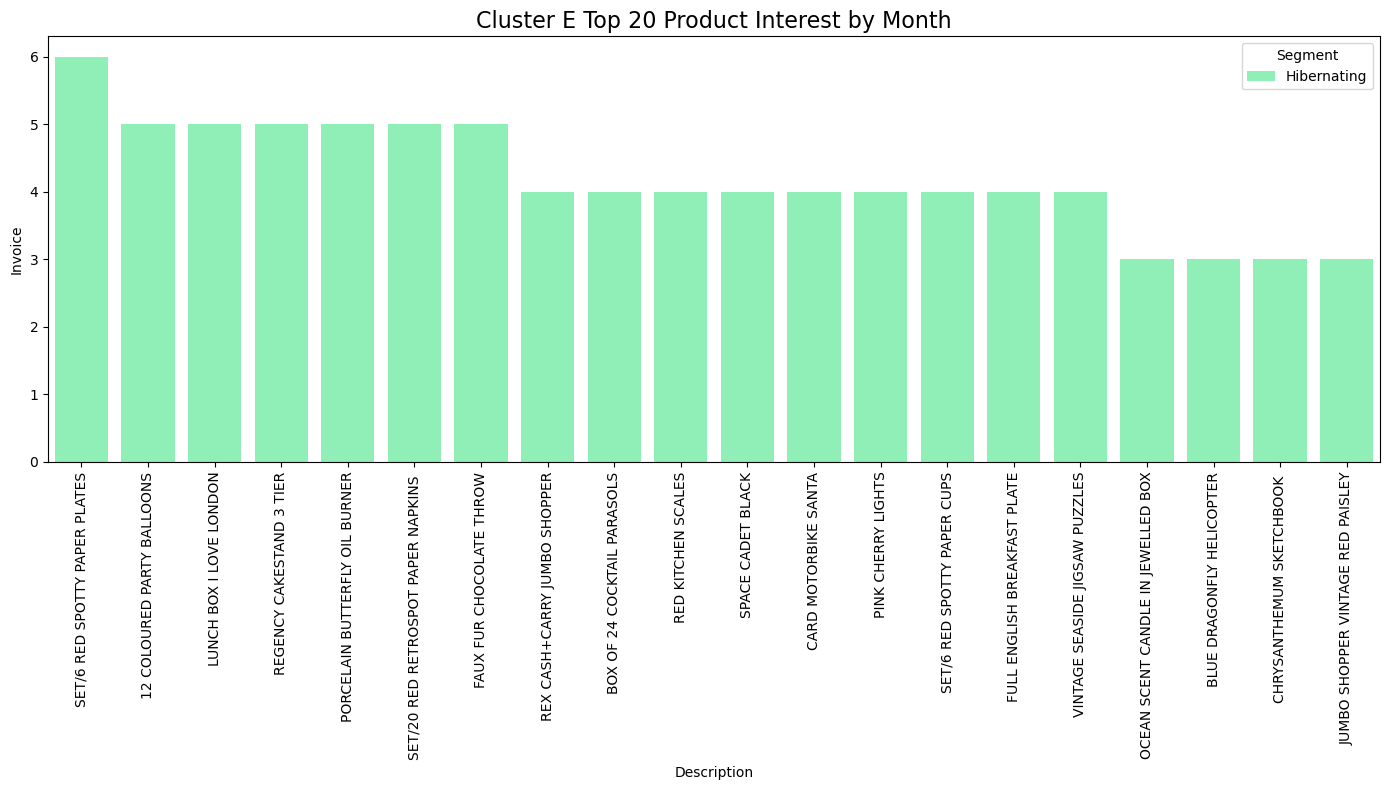

In [64]:
plt.figure(figsize=(14,8))
sns.barplot(x= 'Description', y= 'Invoice',
            data=prod_clus_mth_E.head(20), hue='Segment',
            palette = 'rainbow',
            ci=None)

plt.xticks(rotation=90)
plt.title('Cluster E Top 20 Product Interest by Month', size=16)
plt.tight_layout()
plt.savefig('Cluster E Top 20 Product Interest by Month.jpeg',
            pil_kwargs={'quality': 95,'papertype':'letter'});

# **Product Hour Days Month**

In [65]:
prod_clus_hour_days_month = df.groupby(['ClusterLog','Segment','Description','Hour','Month','Day of Week'], observed=True, as_index=False)[['Invoice']].count().sort_values(by='Invoice', ascending=False)

In [66]:
prod_clus_hour_days_month

,ClusterLog,Segment,Description,Hour,Month,Day of Week,Invoice
598947,Cluster D,Champions,PAPER CHAIN KIT 50'S CHRISTMAS,15,Nov,Wednesday,21
729506,Cluster D,Champions,WHITE HANGING HEART T-LIGHT HOLDER,13,Nov,Tuesday,21
658876,Cluster D,Champions,SCOTTIE DOG HOT WATER BOTTLE,12,Nov,Sunday,19
729510,Cluster D,Champions,WHITE HANGING HEART T-LIGHT HOLDER,13,Nov,Sunday,19
523631,Cluster D,Champions,HAND WARMER OWL DESIGN,12,Nov,Wednesday,18
...,...,...,...,...,...,...,...
285037,Cluster A,Loyal customers,WOODEN TREE CHRISTMAS SCANDINAVIAN,12,Sep,Wednesday,1
285038,Cluster A,Loyal customers,WOODEN TREE CHRISTMAS SCANDINAVIAN,12,Sep,Sunday,1
285040,Cluster A,Loyal customers,WOODEN TREE CHRISTMAS SCANDINAVIAN,12,Nov,Monday,1
285041,Cluster A,Loyal customers,WOODEN TREE CHRISTMAS SCANDINAVIAN,13,Sep,Tuesday,1


## Cluster A

In [67]:
prod_clus_hour_days_month_A = prod_clus_hour_days_month[prod_clus_hour_days_month['ClusterLog'] == 'Cluster A'].sort_values(by='Invoice', ascending=False).head(50)
prod_clus_hour_days_month_A

,ClusterLog,Segment,Description,Hour,Month,Day of Week,Invoice
223466,Cluster A,Loyal customers,JUMBO BAG RED RETROSPOT,15,May,Tuesday,13
240240,Cluster A,Loyal customers,PAPER BUNTING RETROSPOT,15,May,Tuesday,12
224513,Cluster A,Loyal customers,JUMBO SHOPPER VINTAGE RED PAISLEY,15,May,Tuesday,12
35288,Cluster A,At risk,ROTATING LEAVES T-LIGHT HOLDER,15,Dec,Tuesday,10
153387,Cluster A,Can't loose them,SMALL DOLLY MIX DESIGN ORANGE BOWL,9,Jan,Monday,10
222205,Cluster A,Loyal customers,JUMBO BAG BAROQUE BLACK WHITE,15,May,Tuesday,10
111971,Cluster A,Can't loose them,"METAL SIGN,CUPCAKE SINGLE HOOK",9,Jan,Monday,10
32772,Cluster A,At risk,RED SPOTTY BISCUIT TIN,15,Dec,Tuesday,10
223631,Cluster A,Loyal customers,JUMBO BAG SCANDINAVIAN BLUE PAISLEY,15,May,Tuesday,10
164527,Cluster A,Can't loose them,VINTAGE PAISLEY STATIONERY SET,9,Jan,Monday,10


In [68]:
prod_clus_hour_days_month_A['Grouped'] = prod_clus_hour_days_month_A.groupby('Invoice')['Description'].transform(lambda x: ','.join(x))
count = Counter()

for row in prod_clus_hour_days_month_A['Grouped']:
    row_list = row.split(',')
    count.update(Counter(combinations(row_list, 2)))

count.most_common(10)

[(('METAL SIGN', 'CUPCAKE SINGLE HOOK'), 61),
 (('HEART IVORY TRELLIS SMALL', 'METAL SIGN'), 54),
 (('JUMBO BAG RED RETROSPOT', 'METAL SIGN'), 54),
 (('METAL SIGN', 'METAL SIGN'), 54),
 (('METAL SIGN', 'GREEN REGENCY TEACUP AND SAUCER'), 54),
 (('METAL SIGN', 'RED SPOTTY CANDY BAG'), 54),
 (('METAL SIGN', 'JUMBO STORAGE BAG SUKI'), 54),
 (('METAL SIGN', 'RED RETROSPOT OVEN GLOVE '), 54),
 (('METAL SIGN', 'FLORAL FOLK STATIONERY SET'), 54),
 (('METAL SIGN', 'RED RETROSPOT OVEN GLOVE DOUBLE'), 54)]

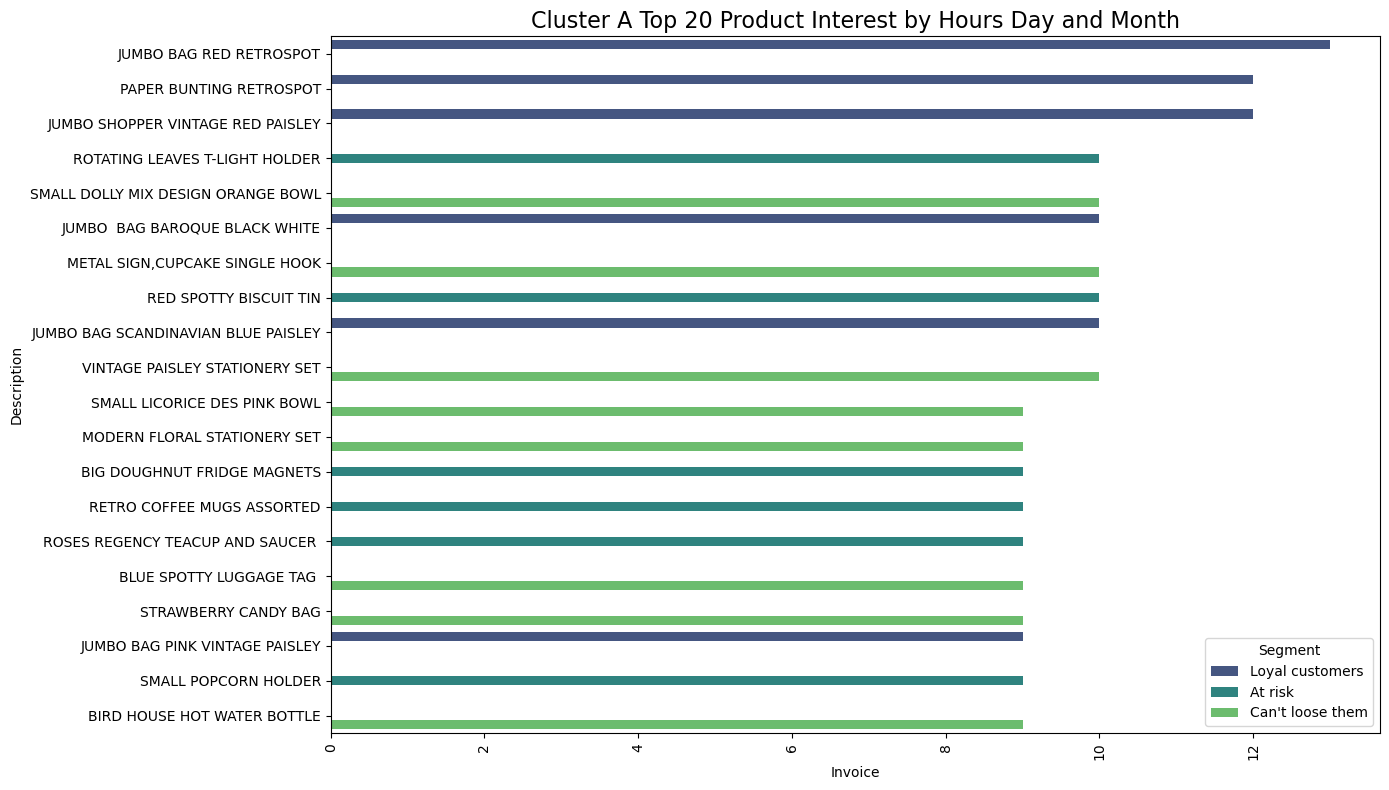

In [69]:
plt.figure(figsize=(14,8))
sns.barplot(x= 'Invoice', y= 'Description',
            data=prod_clus_hour_days_month_A.head(20), hue='Segment',
            palette = 'viridis', orient='h',
            ci=None)

plt.xticks(rotation=90)
plt.title('Cluster A Top 20 Product Interest by Hours Day and Month', size=16)
plt.tight_layout()
plt.savefig('Cluster A Top 20  Product Interest by Hours Day and Month.jpeg',
            pil_kwargs={'quality': 95,'papertype':'letter'});

## Cluster B

In [70]:
prod_clus_hour_days_month_B = prod_clus_hour_days_month[prod_clus_hour_days_month['ClusterLog'] == 'Cluster B'].sort_values(by='Invoice', ascending=False).head(50)
prod_clus_hour_days_month_B

,ClusterLog,Segment,Description,Hour,Month,Day of Week,Invoice
312393,Cluster B,Champions,REX CASH+CARRY JUMBO SHOPPER,15,Nov,Monday,6
302358,Cluster B,Champions,HOT WATER BOTTLE TEA AND SYMPATHY,11,Nov,Sunday,6
302294,Cluster B,Champions,HOT WATER BOTTLE KEEP CALM,12,Nov,Sunday,6
305039,Cluster B,Champions,LUNCH BAG SPACEBOY DESIGN,11,Nov,Sunday,6
312342,Cluster B,Champions,REX CASH+CARRY JUMBO SHOPPER,12,Nov,Friday,5
302248,Cluster B,Champions,HOT WATER BOTTLE I AM SO POORLY,12,Nov,Sunday,5
301067,Cluster B,Champions,HAND WARMER SCOTTY DOG DESIGN,12,Oct,Friday,5
312343,Cluster B,Champions,REX CASH+CARRY JUMBO SHOPPER,12,Nov,Sunday,5
300902,Cluster B,Champions,HAND WARMER BIRD DESIGN,11,Nov,Sunday,5
291383,Cluster B,Champions,ASSORTED COLOUR BIRD ORNAMENT,13,Nov,Sunday,5


In [71]:
prod_clus_hour_days_month_B['Grouped'] = prod_clus_hour_days_month_B.groupby('Invoice')['Description'].transform(lambda x: ','.join(x))
count = Counter()

for row in prod_clus_hour_days_month_B['Grouped']:
    row_list = row.split(',')
    count.update(Counter(combinations(row_list, 2)))

count.most_common(10)

[(("PAPER CHAIN KIT 50'S CHRISTMAS ", 'REX CASH+CARRY JUMBO SHOPPER'), 592),
 (('HAND WARMER SCOTTY DOG DESIGN', 'REX CASH+CARRY JUMBO SHOPPER'), 453),
 (("PAPER CHAIN KIT 50'S CHRISTMAS ", 'HAND WARMER SCOTTY DOG DESIGN'), 444),
 (('REX CASH+CARRY JUMBO SHOPPER', 'REX CASH+CARRY JUMBO SHOPPER'), 231),
 (("PAPER CHAIN KIT 50'S CHRISTMAS ", "PAPER CHAIN KIT 50'S CHRISTMAS "), 222),
 (("PAPER CHAIN KIT 50'S CHRISTMAS ", 'FELTCRAFT HAIRBAND RED AND BLUE'), 148),
 (("PAPER CHAIN KIT 50'S CHRISTMAS ", 'JAZZ HEARTS PURSE NOTEBOOK'), 148),
 (("PAPER CHAIN KIT 50'S CHRISTMAS ", 'JUMBO BAG VINTAGE DOILY '), 148),
 (("PAPER CHAIN KIT 50'S CHRISTMAS ", 'HEART OF WICKER SMALL'), 148),
 (("PAPER CHAIN KIT 50'S CHRISTMAS ", 'HERB MARKER THYME'), 148)]

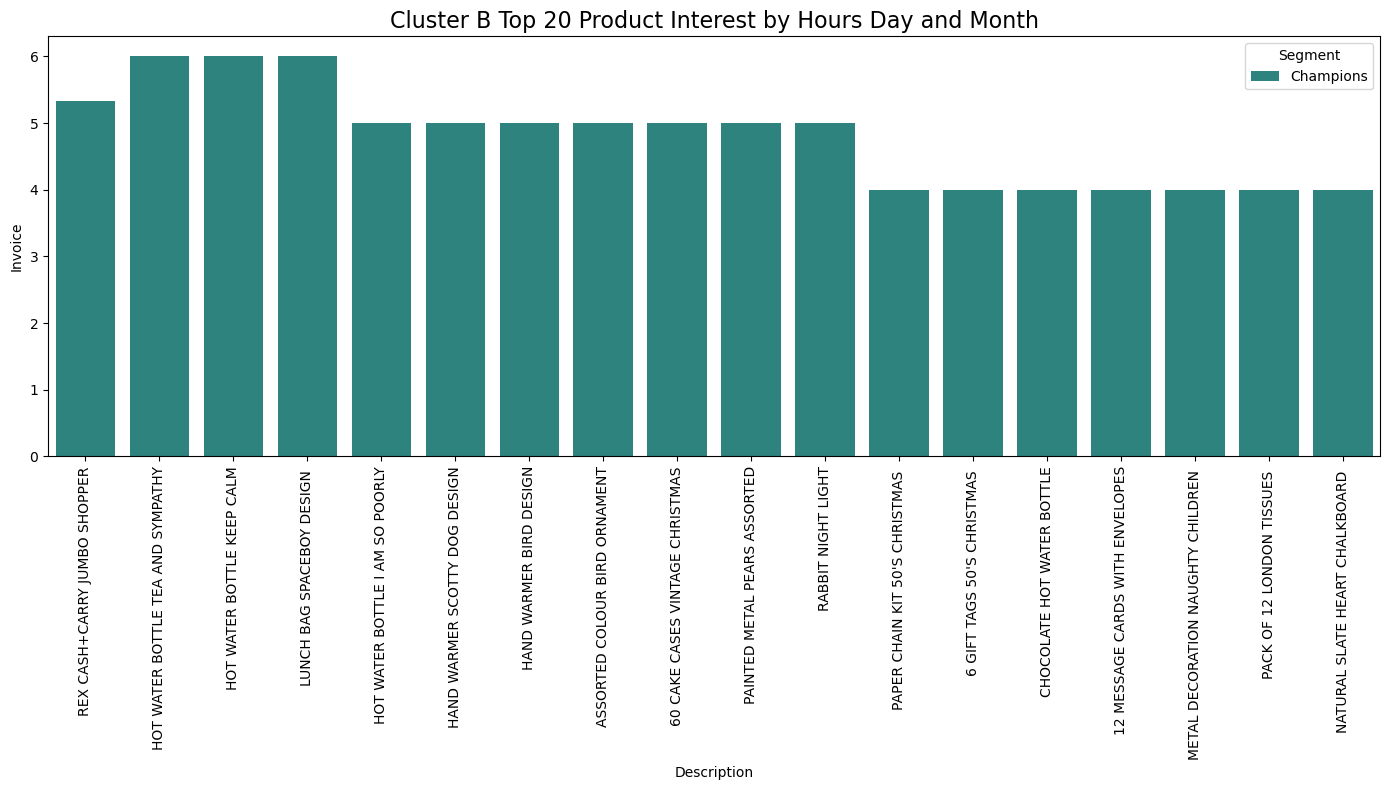

In [72]:
plt.figure(figsize=(14,8))
sns.barplot(x= 'Description', y= 'Invoice',
            data=prod_clus_hour_days_month_B.head(20), hue='Segment',
            palette = 'viridis',
            ci=None)

plt.xticks(rotation=90)
plt.title('Cluster B Top 20 Product Interest by Hours Day and Month', size=16)
plt.tight_layout()
plt.savefig('Cluster B Top 20  Product Interest by Hours Day and Month.jpeg',
            pil_kwargs={'quality': 95,'papertype':'letter'});

## Cluster C

In [73]:
prod_clus_hour_days_month_C = prod_clus_hour_days_month[prod_clus_hour_days_month['ClusterLog'] == 'Cluster C'].sort_values(by='Invoice', ascending=False).head(50)
prod_clus_hour_days_month_C

,ClusterLog,Segment,Description,Hour,Month,Day of Week,Invoice
368817,Cluster C,Hibernating,FUNKY FLOWER PICNIC BAG FOR 4,12,May,Wednesday,14
376343,Cluster C,Hibernating,PACK OF 72 RETRO SPOT CAKE CASES,11,Jun,Thursday,13
381038,Cluster C,Hibernating,REGENCY CAKESTAND 3 TIER,12,Jul,Thursday,12
376973,Cluster C,Hibernating,PARTY BUNTING,12,May,Wednesday,12
391115,Cluster C,Loyal customers,JUMBO STORAGE BAG SUKI,15,May,Tuesday,10
394274,Cluster C,Potential loyalists,JUMBO STORAGE BAG SUKI,15,Jun,Wednesday,10
372177,Cluster C,Hibernating,JUMBO BAG RED RETROSPOT,11,Jul,Wednesday,10
389453,Cluster C,Hibernating,WOODEN BOX ADVENT CALENDAR,14,Dec,Tuesday,10
376754,Cluster C,Hibernating,PAPER CHAIN KIT 50'S CHRISTMAS,14,Dec,Tuesday,10
391096,Cluster C,Loyal customers,JUMBO SHOPPER VINTAGE RED PAISLEY,15,May,Tuesday,10


In [74]:
prod_clus_hour_days_month_C['Grouped'] = prod_clus_hour_days_month_C.groupby('Invoice')['Description'].transform(lambda x: ','.join(x))
count = Counter()

for row in prod_clus_hour_days_month_C['Grouped']:
    row_list = row.split(',')
    count.update(Counter(combinations(row_list, 2)))

count.most_common(10)

[(('BINGO SET', 'JUMBO BAG RED RETROSPOT'), 52),
 (('BINGO SET', 'OWL DOORSTOP'), 52),
 (('RED SPOTTY CHARLOTTE BAG', 'JUMBO BAG RED RETROSPOT'), 52),
 (('RED SPOTTY CHARLOTTE BAG', 'OWL DOORSTOP'), 52),
 (('JUMBO BAG WOODLAND ANIMALS', 'JUMBO BAG RED RETROSPOT'), 52),
 (('JUMBO BAG WOODLAND ANIMALS', 'OWL DOORSTOP'), 52),
 (('JUMBO BAG TOYS ', 'JUMBO BAG RED RETROSPOT'), 52),
 (('JUMBO BAG TOYS ', 'OWL DOORSTOP'), 52),
 (('JUMBO BAG SCANDINAVIAN BLUE PAISLEY', 'JUMBO BAG RED RETROSPOT'), 52),
 (('JUMBO BAG SCANDINAVIAN BLUE PAISLEY', 'OWL DOORSTOP'), 52)]

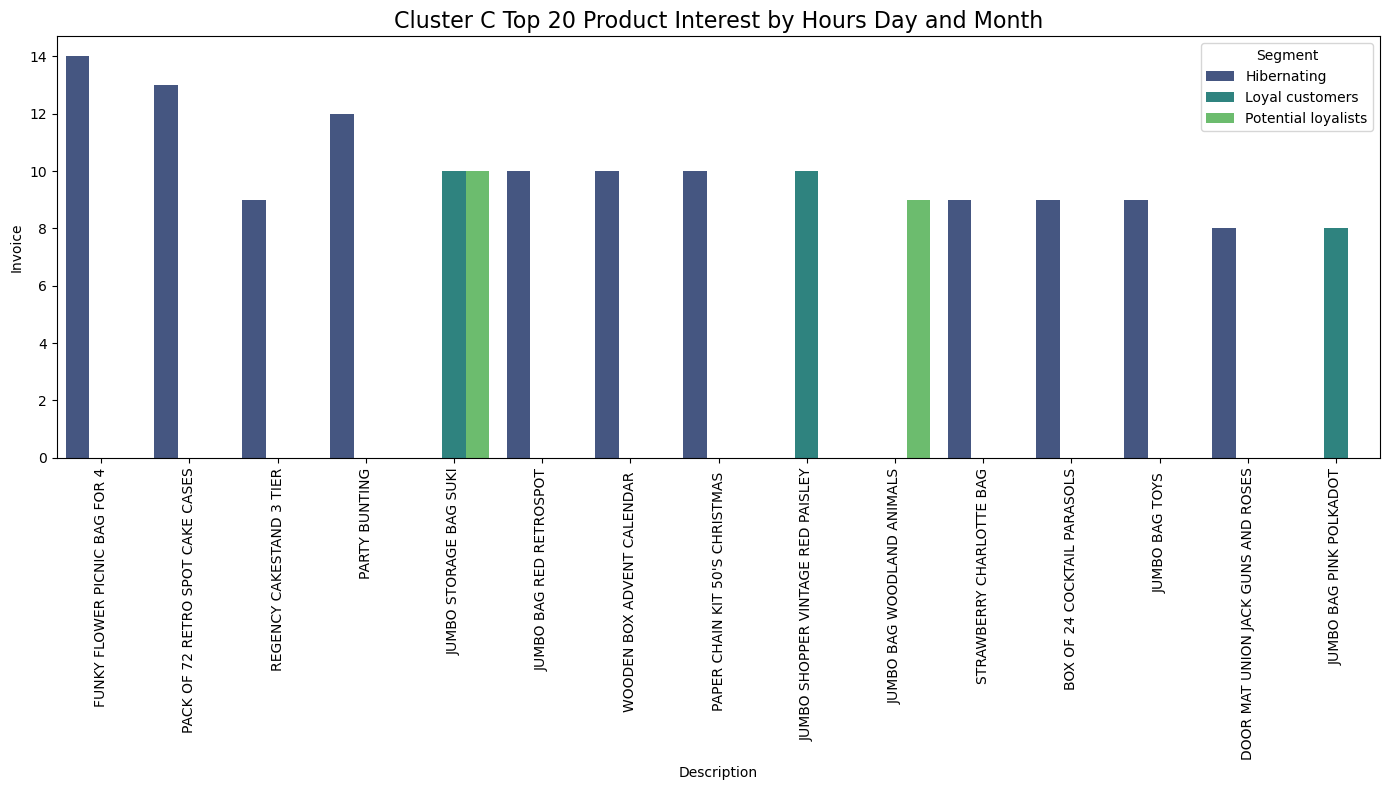

In [75]:
plt.figure(figsize=(14,8))
sns.barplot(x= 'Description', y= 'Invoice',
            data=prod_clus_hour_days_month_C.head(20), hue='Segment',
            palette = 'viridis',
            ci=None)

plt.xticks(rotation=90)
plt.title('Cluster C Top 20 Product Interest by Hours Day and Month', size=16)
plt.tight_layout()
plt.savefig('Cluster C Top 20  Product Interest by Hours Day and Month.jpeg',
            pil_kwargs={'quality': 95,'papertype':'letter'});

## Cluster D

In [76]:
prod_clus_hour_days_month_D = prod_clus_hour_days_month[prod_clus_hour_days_month['ClusterLog'] == 'Cluster D'].sort_values(by='Invoice', ascending=False).head(50)
prod_clus_hour_days_month_D

,ClusterLog,Segment,Description,Hour,Month,Day of Week,Invoice
598947,Cluster D,Champions,PAPER CHAIN KIT 50'S CHRISTMAS,15,Nov,Wednesday,21
729506,Cluster D,Champions,WHITE HANGING HEART T-LIGHT HOLDER,13,Nov,Tuesday,21
658876,Cluster D,Champions,SCOTTIE DOG HOT WATER BOTTLE,12,Nov,Sunday,19
729510,Cluster D,Champions,WHITE HANGING HEART T-LIGHT HOLDER,13,Nov,Sunday,19
523631,Cluster D,Champions,HAND WARMER OWL DESIGN,12,Nov,Wednesday,18
546631,Cluster D,Champions,JUMBO BAG RED RETROSPOT,13,Nov,Tuesday,17
729512,Cluster D,Champions,WHITE HANGING HEART T-LIGHT HOLDER,13,Dec,Tuesday,17
523659,Cluster D,Champions,HAND WARMER OWL DESIGN,13,Nov,Sunday,17
523425,Cluster D,Champions,HAND WARMER BIRD DESIGN,12,Nov,Wednesday,16
624092,Cluster D,Champions,RABBIT NIGHT LIGHT,13,Nov,Monday,16


In [77]:
prod_clus_hour_days_month_D['Grouped'] = prod_clus_hour_days_month_D.groupby('Invoice')['Description'].transform(lambda x: ','.join(x))
count = Counter()

for row in prod_clus_hour_days_month_D['Grouped']:
    row_list = row.split(',')
    count.update(Counter(combinations(row_list, 2)))

count.most_common(10)

[(('WHITE HANGING HEART T-LIGHT HOLDER', 'WHITE HANGING HEART T-LIGHT HOLDER'),
  150),
 (('WHITE HANGING HEART T-LIGHT HOLDER', "PAPER CHAIN KIT 50'S CHRISTMAS "),
  148),
 (('WHITE HANGING HEART T-LIGHT HOLDER', 'JUMBO BAG RED RETROSPOT'), 116),
 (('JUMBO BAG RED RETROSPOT', 'WHITE HANGING HEART T-LIGHT HOLDER'), 79),
 (('SET OF 20 VINTAGE CHRISTMAS NAPKINS',
   'WHITE HANGING HEART T-LIGHT HOLDER'),
  64),
 (('REX CASH+CARRY JUMBO SHOPPER', 'WHITE HANGING HEART T-LIGHT HOLDER'), 52),
 (('WHITE HANGING HEART T-LIGHT HOLDER', 'RABBIT NIGHT LIGHT'), 52),
 (('WHITE HANGING HEART T-LIGHT HOLDER', 'JUMBO STORAGE BAG SUKI'), 52),
 (('WHITE HANGING HEART T-LIGHT HOLDER', 'HOT WATER BOTTLE KEEP CALM'), 52),
 (('WHITE HANGING HEART T-LIGHT HOLDER', 'HAND WARMER OWL DESIGN'), 51)]

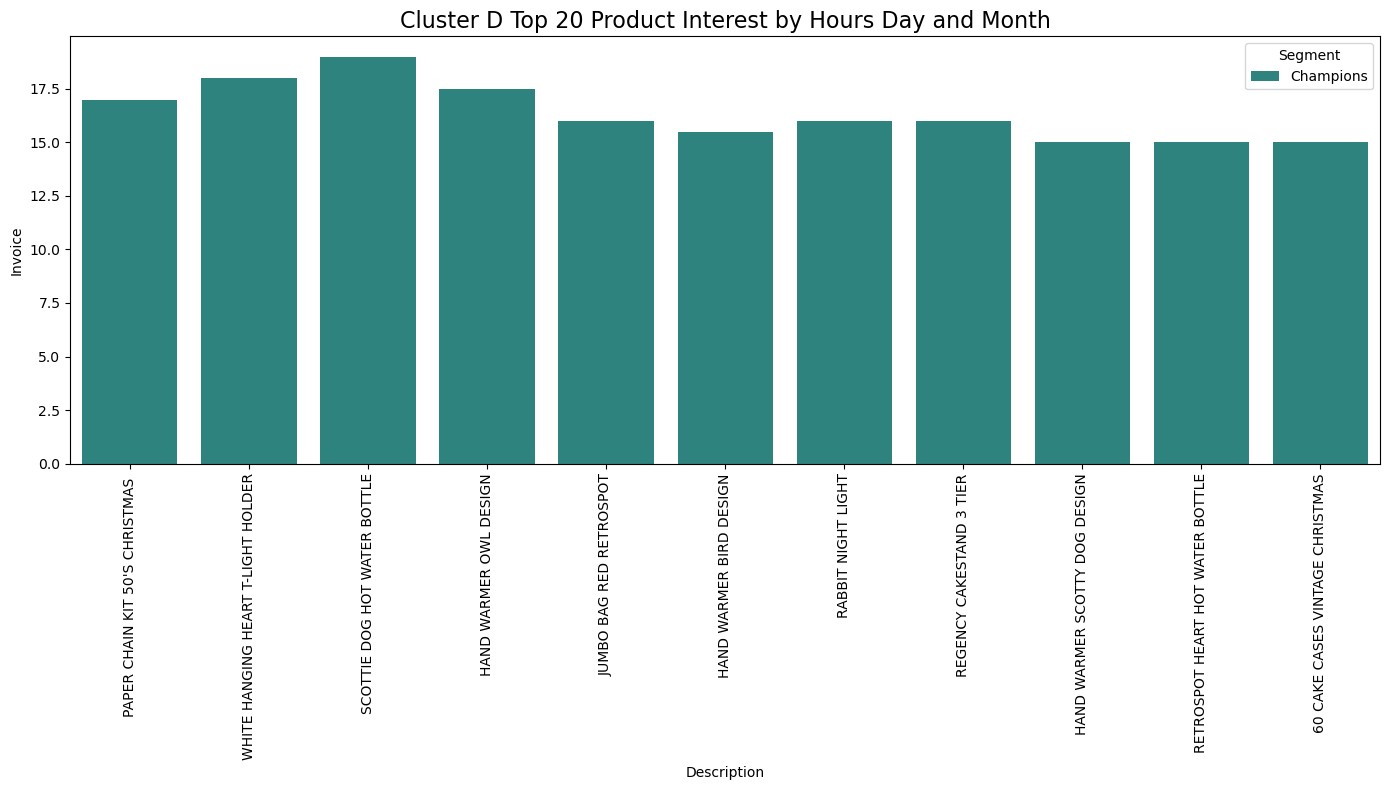

In [78]:
plt.figure(figsize=(14,8))
sns.barplot(x= 'Description', y= 'Invoice',
            data=prod_clus_hour_days_month_D.head(20), hue='Segment',
            palette = 'viridis',
            ci=None)

plt.xticks(rotation=90)
plt.title('Cluster D Top 20 Product Interest by Hours Day and Month', size=16)
plt.tight_layout()
plt.savefig('Cluster D Top 20  Product Interest by Hours Day and Month.jpeg',
            pil_kwargs={'quality': 95,'papertype':'letter'});

## Cluster E

In [79]:
prod_clus_hour_days_month_E = prod_clus_hour_days_month[prod_clus_hour_days_month['ClusterLog'] == 'Cluster E'].sort_values(by='Invoice', ascending=False).head(50)
prod_clus_hour_days_month_E

,ClusterLog,Segment,Description,Hour,Month,Day of Week,Invoice
794624,Cluster E,Hibernating,SET OF 12 LILY BOTANICAL T-LIGHTS,17,Aug,Tuesday,3
794135,Cluster E,Hibernating,PENNY FARTHING BIRTHDAY CARD,17,Aug,Tuesday,3
793047,Cluster E,Hibernating,CHILDRENS GARDEN GLOVES BLUE,13,Apr,Monday,3
792945,Cluster E,Hibernating,BOX OF 24 COCKTAIL PARASOLS,11,Feb,Monday,3
793938,Cluster E,Hibernating,"METAL SIGN,CUPCAKE SINGLE HOOK",11,Feb,Monday,3
794572,Cluster E,Hibernating,SANDALWOOD FAN,16,Jul,Friday,2
795327,Cluster E,New customers,PACK OF 12 TRADITIONAL CRAYONS,10,Oct,Friday,2
795324,Cluster E,New customers,MULTI HEARTS STICKERS,10,Oct,Friday,2
795697,Cluster E,Promising,MULTI COLOUR SILVER T-LIGHT HOLDER,16,Oct,Monday,2
794746,Cluster E,Hibernating,SET/3 RED GINGHAM ROSE STORAGE BOX,15,Jan,Monday,2


In [80]:
prod_clus_hour_days_month_E['Grouped'] = prod_clus_hour_days_month_E.groupby('Invoice')['Description'].transform(lambda x: ','.join(x))
count = Counter()

for row in prod_clus_hour_days_month_E['Grouped']:
    row_list = row.split(',')
    count.update(Counter(combinations(row_list, 2)))

count.most_common(10)

[(('SPACE CADET BLACK', 'WHITE BAMBOO RIBS LAMPSHADE'), 164),
 (('SANDALWOOD FAN', 'SPACE CADET BLACK'), 82),
 (('SANDALWOOD FAN', 'WHITE BAMBOO RIBS LAMPSHADE'), 82),
 (('PACK OF 12 TRADITIONAL CRAYONS', 'SPACE CADET BLACK'), 82),
 (('PACK OF 12 TRADITIONAL CRAYONS', 'WHITE BAMBOO RIBS LAMPSHADE'), 82),
 (('MULTI HEARTS  STICKERS', 'SPACE CADET BLACK'), 82),
 (('MULTI HEARTS  STICKERS', 'WHITE BAMBOO RIBS LAMPSHADE'), 82),
 (('MULTI COLOUR SILVER T-LIGHT HOLDER', 'SPACE CADET BLACK'), 82),
 (('MULTI COLOUR SILVER T-LIGHT HOLDER', 'WHITE BAMBOO RIBS LAMPSHADE'), 82),
 (('SET/3 RED GINGHAM ROSE STORAGE BOX', 'SPACE CADET BLACK'), 82)]

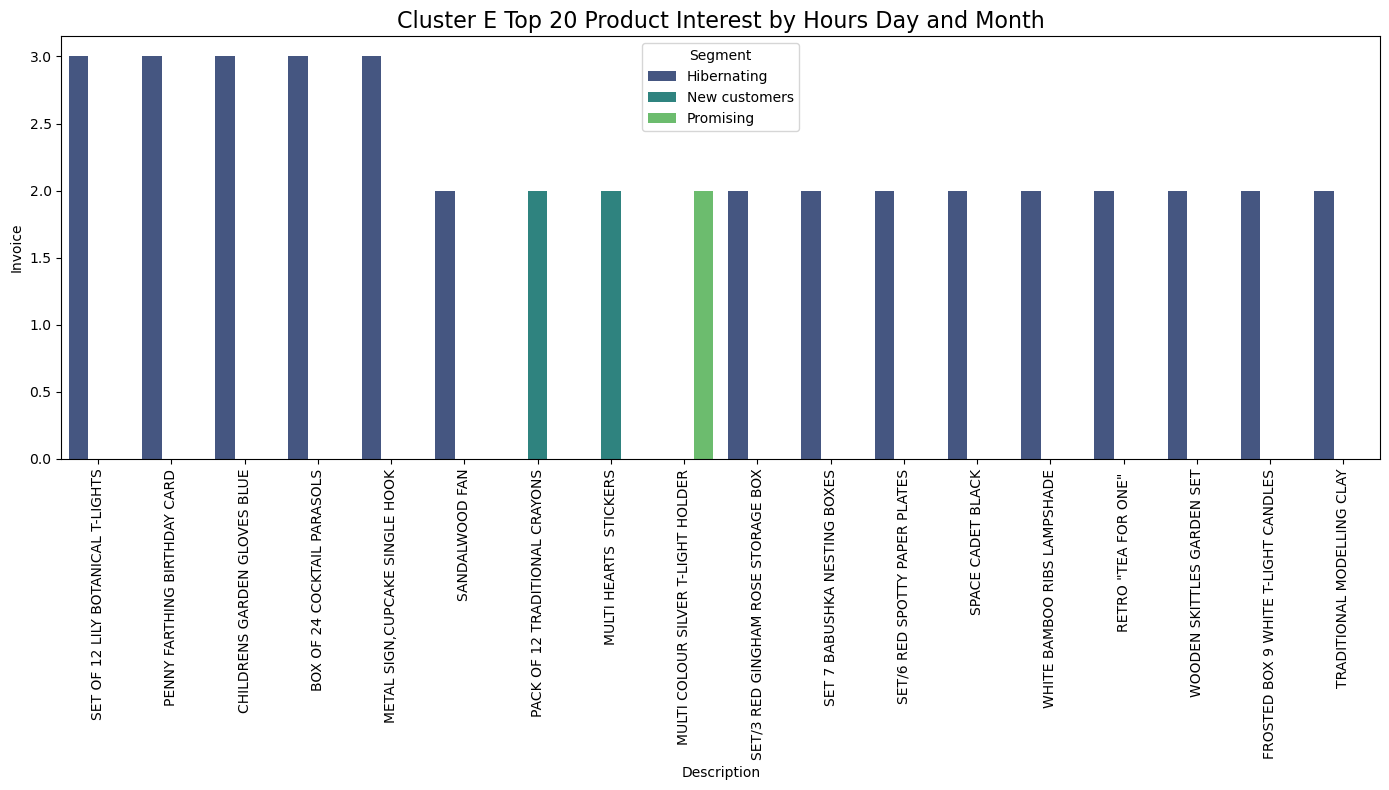

In [81]:
plt.figure(figsize=(14,8))
sns.barplot(x= 'Description', y= 'Invoice',
            data=prod_clus_hour_days_month_E.head(20), hue='Segment',
            palette = 'viridis',
            ci=None)

plt.xticks(rotation=90)
plt.title('Cluster E Top 20 Product Interest by Hours Day and Month', size=16)
plt.tight_layout()
plt.savefig('Cluster E Top 20  Product Interest by Hours Day and Month.jpeg',
            pil_kwargs={'quality': 95,'papertype':'letter'});

# System Recommender

In [82]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
import re
import random
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [83]:
df = pd.read_csv('Clustering All.csv', usecols=['Description'])
df = pd.DataFrame({'Description':df['Description'].unique()})

clean_spcl = re.compile('[/(){}\[\]\|@,;]')
clean_symbol = re.compile('[^0-9a-z #+_]')
stopworda = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = clean_spcl.sub(' ', text)
    text = clean_symbol.sub('', text)
    text = ' '.join(word for word in text.split() if word not in stopworda) # Cleaning a stopword
    return text

df['Desc_Clean'] = df['Description'].apply(clean_text)

In [91]:
cv = CountVectorizer()
count_matrix = cv.fit_transform(df['Desc_Clean'])
cos_sim = cosine_similarity(count_matrix)


product_user_likes = clean_text('WHITE HANGING HEART T-LIGHT HOLDER')
df['index'] = df.index

def index_from(desc):
    return df[df['Desc_Clean'] == desc]["index"].values[0]

def desc_from(indx):
    return df[df['index'] == indx]['Description'].values[0]

desc_indx = index_from(product_user_likes)

similiar_desc = list(enumerate(cos_sim[desc_indx]))

sorted_similiar = sorted(similiar_desc,key=lambda x:x[1],reverse=True)

recommendation = []
for i  in sorted_similiar[1:10]:
    recommendation.append(desc_from(i[0]))
recommendation

['HANGING HEART ZINC T-LIGHT HOLDER',
 'RED HANGING HEART T-LIGHT HOLDER',
 'HANGING HEART JAR T-LIGHT HOLDER',
 'CREAM HANGING HEART T-LIGHT HOLDER',
 'PINK HANGING HEART T-LIGHT HOLDER',
 'HEART T-LIGHT HOLDER',
 'HEART T-LIGHT HOLDER ',
 'GLASS HEART T-LIGHT HOLDER ',
 'SILVER HANGING T-LIGHT HOLDER']

Testing Product Recommender Cluster A Top 20 Products in Month over a Year

In [ ]:
['WHITE HANGING HEART T-LIGHT HOLDER',
 'SCOTTIE DOG HOT WATER BOTTLE',
 'WHITE HANGING HEART T-LIGHT HOLDER',
 'WHITE HANGING HEART T-LIGHT HOLDER',
 'WHITE HANGING HEART T-LIGHT HOLDER',
 'WHITE HANGING HEART T-LIGHT HOLDER',
 'KNITTED UNION FLAG HOT WATER BOTTLE',
 'WHITE HANGING HEART T-LIGHT HOLDER',
 'PARTY BUNTING',
 'JUMBO BAG RED RETROSPOT',
 "PAPER CHAIN KIT 50'S CHRISTMAS ",
 'REGENCY CAKESTAND 3 TIER',
 'WHITE HANGING HEART T-LIGHT HOLDER',
 'CHOCOLATE HOT WATER BOTTLE',
 'METAL SIGN,CUPCAKE SINGLE HOOK',
 'PARTY BUNTING',
 'WHITE HANGING HEART T-LIGHT HOLDER',
 'WHITE SKULL HOT WATER BOTTLE ',
 'RED WOOLLY HOTTIE WHITE HEART.',
 'STRAWBERRY CERAMIC TRINKET BOX']

In [ ]:
'ASSORTED COLOURS SILK FAN', 'VICTORIAN GLASS HANGING T-LIGHT'